## Freed, 2012. Using short-term postseismic displacements to infer the ambient deformation conditoions of the upper mantle

In [5]:
import math
import numpy as np

def calc_T(z, Ts, Ti, G, thid):
    DEL = 2*(Ti-Ts)/(G*np.sqrt(np.pi))
    if thid == 2:
        T = [Ts+(Ti-Ts)*math.erf(z[i]/DEL) for i in range(len(z))]
        T = np.array(T)
    else:
        T = Ts+z*G
    return T

In [6]:
import numpy as np
import logging

class flow_law(object):
    '''
    A power law dependence of strain rate on differential stress.
                                          Q+PV  
    epsilon = A*signma^n*d^(-m)*Coh^r*exp(----)
                                          -RT
    epsilon is strain rate
    '''
    def __init__(self, A, n, d, m, Coh, r, Q, P, V, T, R=8.314, sigma=None, epsilon=None):
        '''
        If m is 0, dislocation creep
        If n is 0, diffisioin creep
            A     = pre-exponential factor, 1/(MPa^(-n)*s)
            n     = stress exponent
            d     = grain size, um = 1e-6 m
            m     = grain size exponent
            Coh   = water concentration, ppm H/Si
            r     = water concentration exponent
            Q     = activation energy, J/mol
            p     = confining pressure, Pa
            V     = activation volume, m^3/mol
            R     = universal gas constant, J/(mol*K)
            T     = temperature, (K)
            sigma = deviatoric stress, Pa
            epsilon = strain rate in /s
        '''

        self.A     = A
        self.n     = n
        self.d     = d
        self.m     = m
        self.Coh   = Coh
        self.r     = r
        self.Q     = Q
        self.P     = P
        self.V     = V
        self.R     = R
        self.T     = T
        self.sigma = sigma
        self.epsilon=epsilon
        return


    def get_strain_rate(self):
        '''
        Compute strain rate ε given stress σ.
        '''
        if self.sigma is None:
            logging.warning("σ (stress) not set. Cannot compute ε.")
            return None

        strain_rate = (self.A * 
                       self.d**(-self.m) *
                       self.Coh**self.r *
                       self.sigma**self.n *
                       np.exp(-(self.Q+self.P*self.V)/(self.R*self.T)))
        return strain_rate

    def get_viscosity(self):
        '''
        Calculate viscosity.
        '''
        if self.d == 0:
            self.d = 1.0
        if self.Coh == 0:
            self.Coh = 1.0
        print(self.Coh, self.d)
            
        # equation (7) of Freed et al. 2012
        if self.sigma is None and self.epsilon is not None:
            eta = (self.epsilon ** ((1-self.n)/self.n) *
                   np.exp((self.Q+self.P*self.V)/(self.n*self.R*self.T)) /
                   (self.A*self.d**(-self.m) * self.Coh**self.r)**(1/self.n)/2)
            
        # equation (6) of Freed et al. 2012
        elif self.sigma is not None and self.epsilon is None:
            eta = (np.power(self.sigma, (1-self.n)) *
                   np.exp((self.Q+self.P*self.V)/(self.R*self.T)) /
                   (2 * self.A * self.d**(-self.m)* self.Coh**self.r))
        else:
            logging.warning("Need either σ or ε to compute viscosity.")
            eta = None
        return eta*1e6

    def get_stress(self):
        '''
        Calculate stress σ given strain rate ε.
        '''
        if self.epsilon is None:
            logging.warning("ε (strain rate) not set. Cannot compute σ.")
            return None
        
        sigma = (self.epsilon /
                 self.A /
                 self.d**(-self.m) /
                 self.Coh**self.r /
                 np.exp(-(self.Q+self.P*self.V)/(self.R*self.T)))
        sigma = np.power(sigma, 1/self.n)
        return sigma
    
    @staticmethod
    def plot_tempeature_viscosity(T, eta):
        '''
        '''
        import numpy as np
        import matplotlib.pyplot as plt
        plt.plot(eta, T-273)
        plt.xlabel('Viscosity (Pas)')
        plt.ylabel('Temperature')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.set_xscale('log')
        plt.show()
        
    @staticmethod
    def plot_depth_viscosity(depth, eta):
        '''
        '''
        import numpy as np
        import matplotlib.pyplot as plt
        plt.plot(eta, depth)
        plt.xlabel('Viscosity (Pas)')
        plt.ylabel('Depth (km)')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.set_xscale('log')
        plt.show()
        
    @staticmethod
    def plot_depth_stress(depth, stress):
        '''
        '''
        import numpy as np
        import matplotlib.pyplot as plt
        plt.plot(stress, depth)
        plt.xlabel('Stress (MPa)')
        plt.ylabel('Depth (km)')
        ax = plt.gca()
        ax.invert_yaxis()
        plt.show()

In [12]:
import pandas as pd
#import calc_temperature
import numpy as np
#import rheology
import matplotlib.pyplot as plt

def plot_rheology(vis1, vis2, dep, T, label_1="", label_2=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6), dpi=300)
    ax1.plot(vis1, dep, label=label_1)
    ax1.plot(vis2, dep, label=label_2)
    ax1.set_xscale('log')
    ax1.set_ylim([30,100])
    ax1.set_xlim([1e17,1e24])
    ax1.legend()
    ax1.set_xlabel('Viscosity (Pa.s)')
    ax1.set_ylabel('Depth (km)')
    ax1.grid(True, which="both", ls="--", alpha=0.5)
    ax1.invert_yaxis()
    
    ax2.plot(T, dep, color="red")
    ax2.set_xlim(min(T), max(T))
    ax2.set_xlabel("Temperature (K)")
    ax2.grid(True, ls="--", alpha=0.5)
    ax2.set_ylim([30,100])
    ax2.invert_yaxis()
    plt.tight_layout()
    plt.show()


## Dislocation: Sensitive to background strain rate

2.970000e+09
1000 1.0
1000 1.0


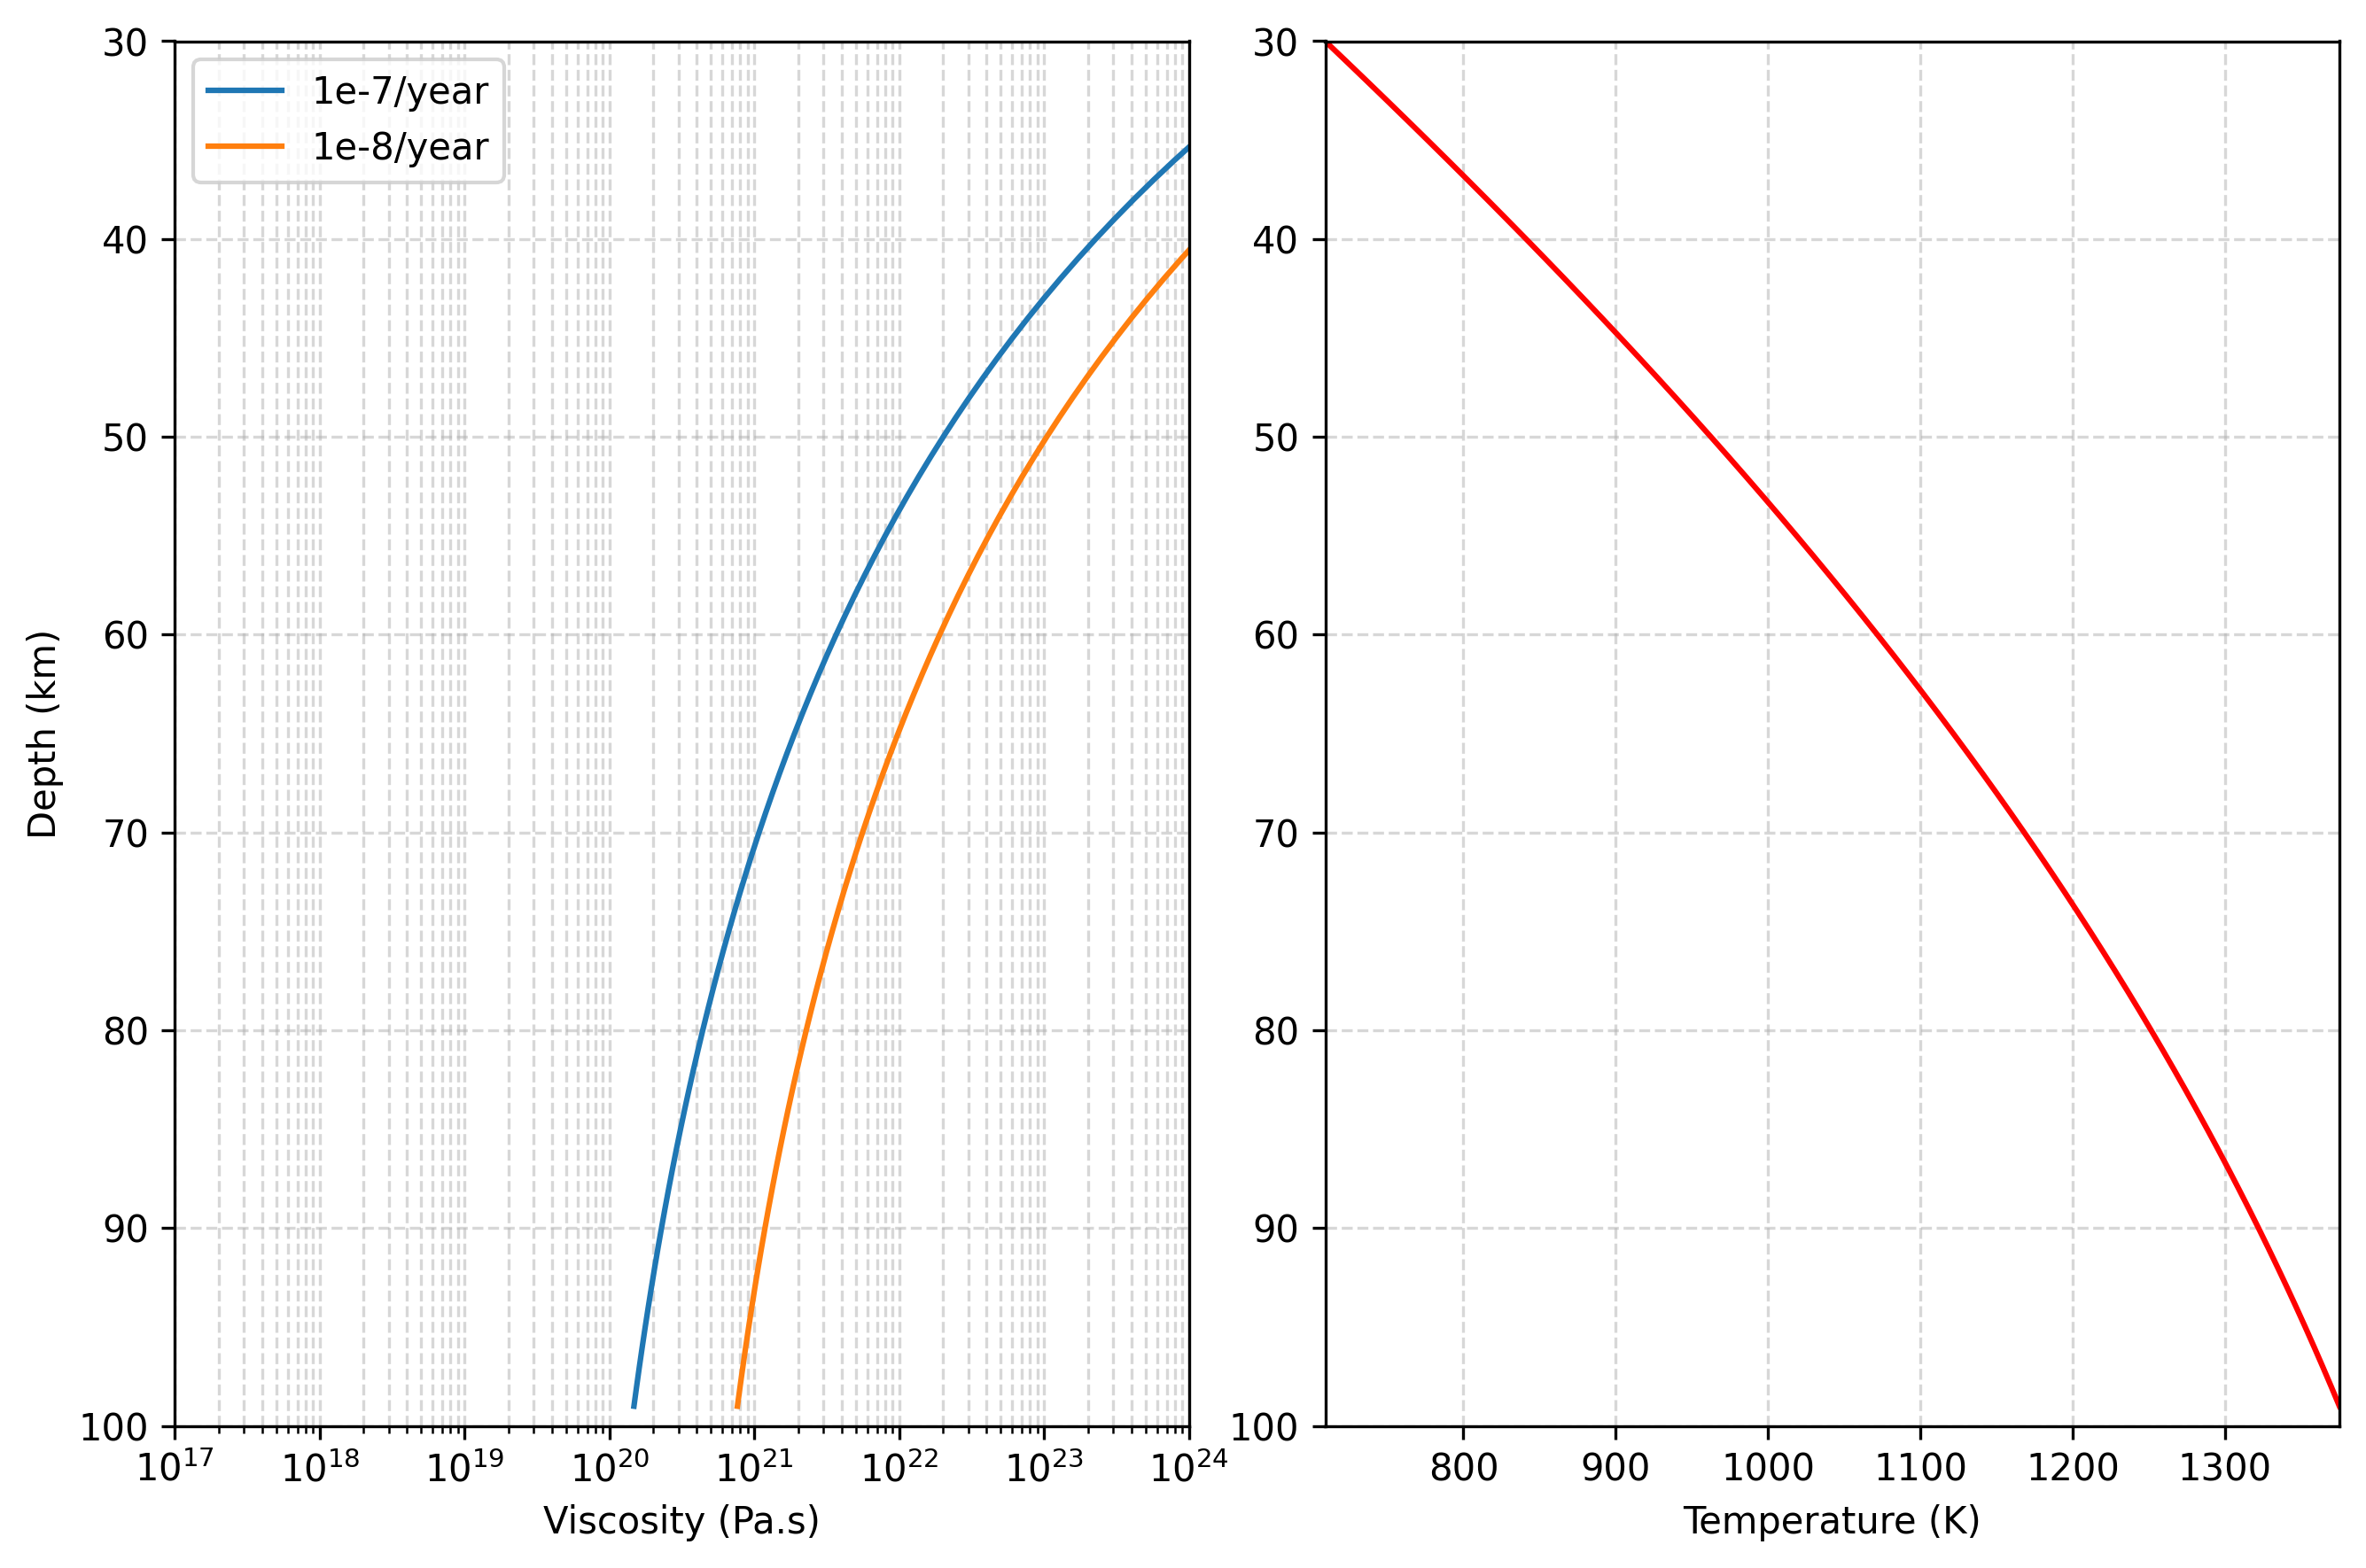

In [13]:
depth = np.arange(0,100,1)
P     = 3000 * 10 * depth * 1e3
print(f'{max(P):e}')
T     = calc_temperature.calc_T(depth, 0, 1300, 15, 2)+273
idx   = np.where(depth>=30)[0]

rh1   = rheology.flow_law(30, 3.5, 0, 0, 1000, 1.2, 480e3, P[idx], 11e-6, T[idx], epsilon=3.175e-15)
rh2   = rheology.flow_law(30, 3.5, 0, 0, 1000, 1.2, 480e3, P[idx], 11e-6, T[idx], epsilon=3.175e-16)
plot_rheology(rh1.get_viscosity(), rh2.get_viscosity(), depth[idx], T[idx], label_1="1e-7/year", label_2="1e-8/year")

## Dislocation: Sensitive to stress exponent

1000 1.0
1000 1.0


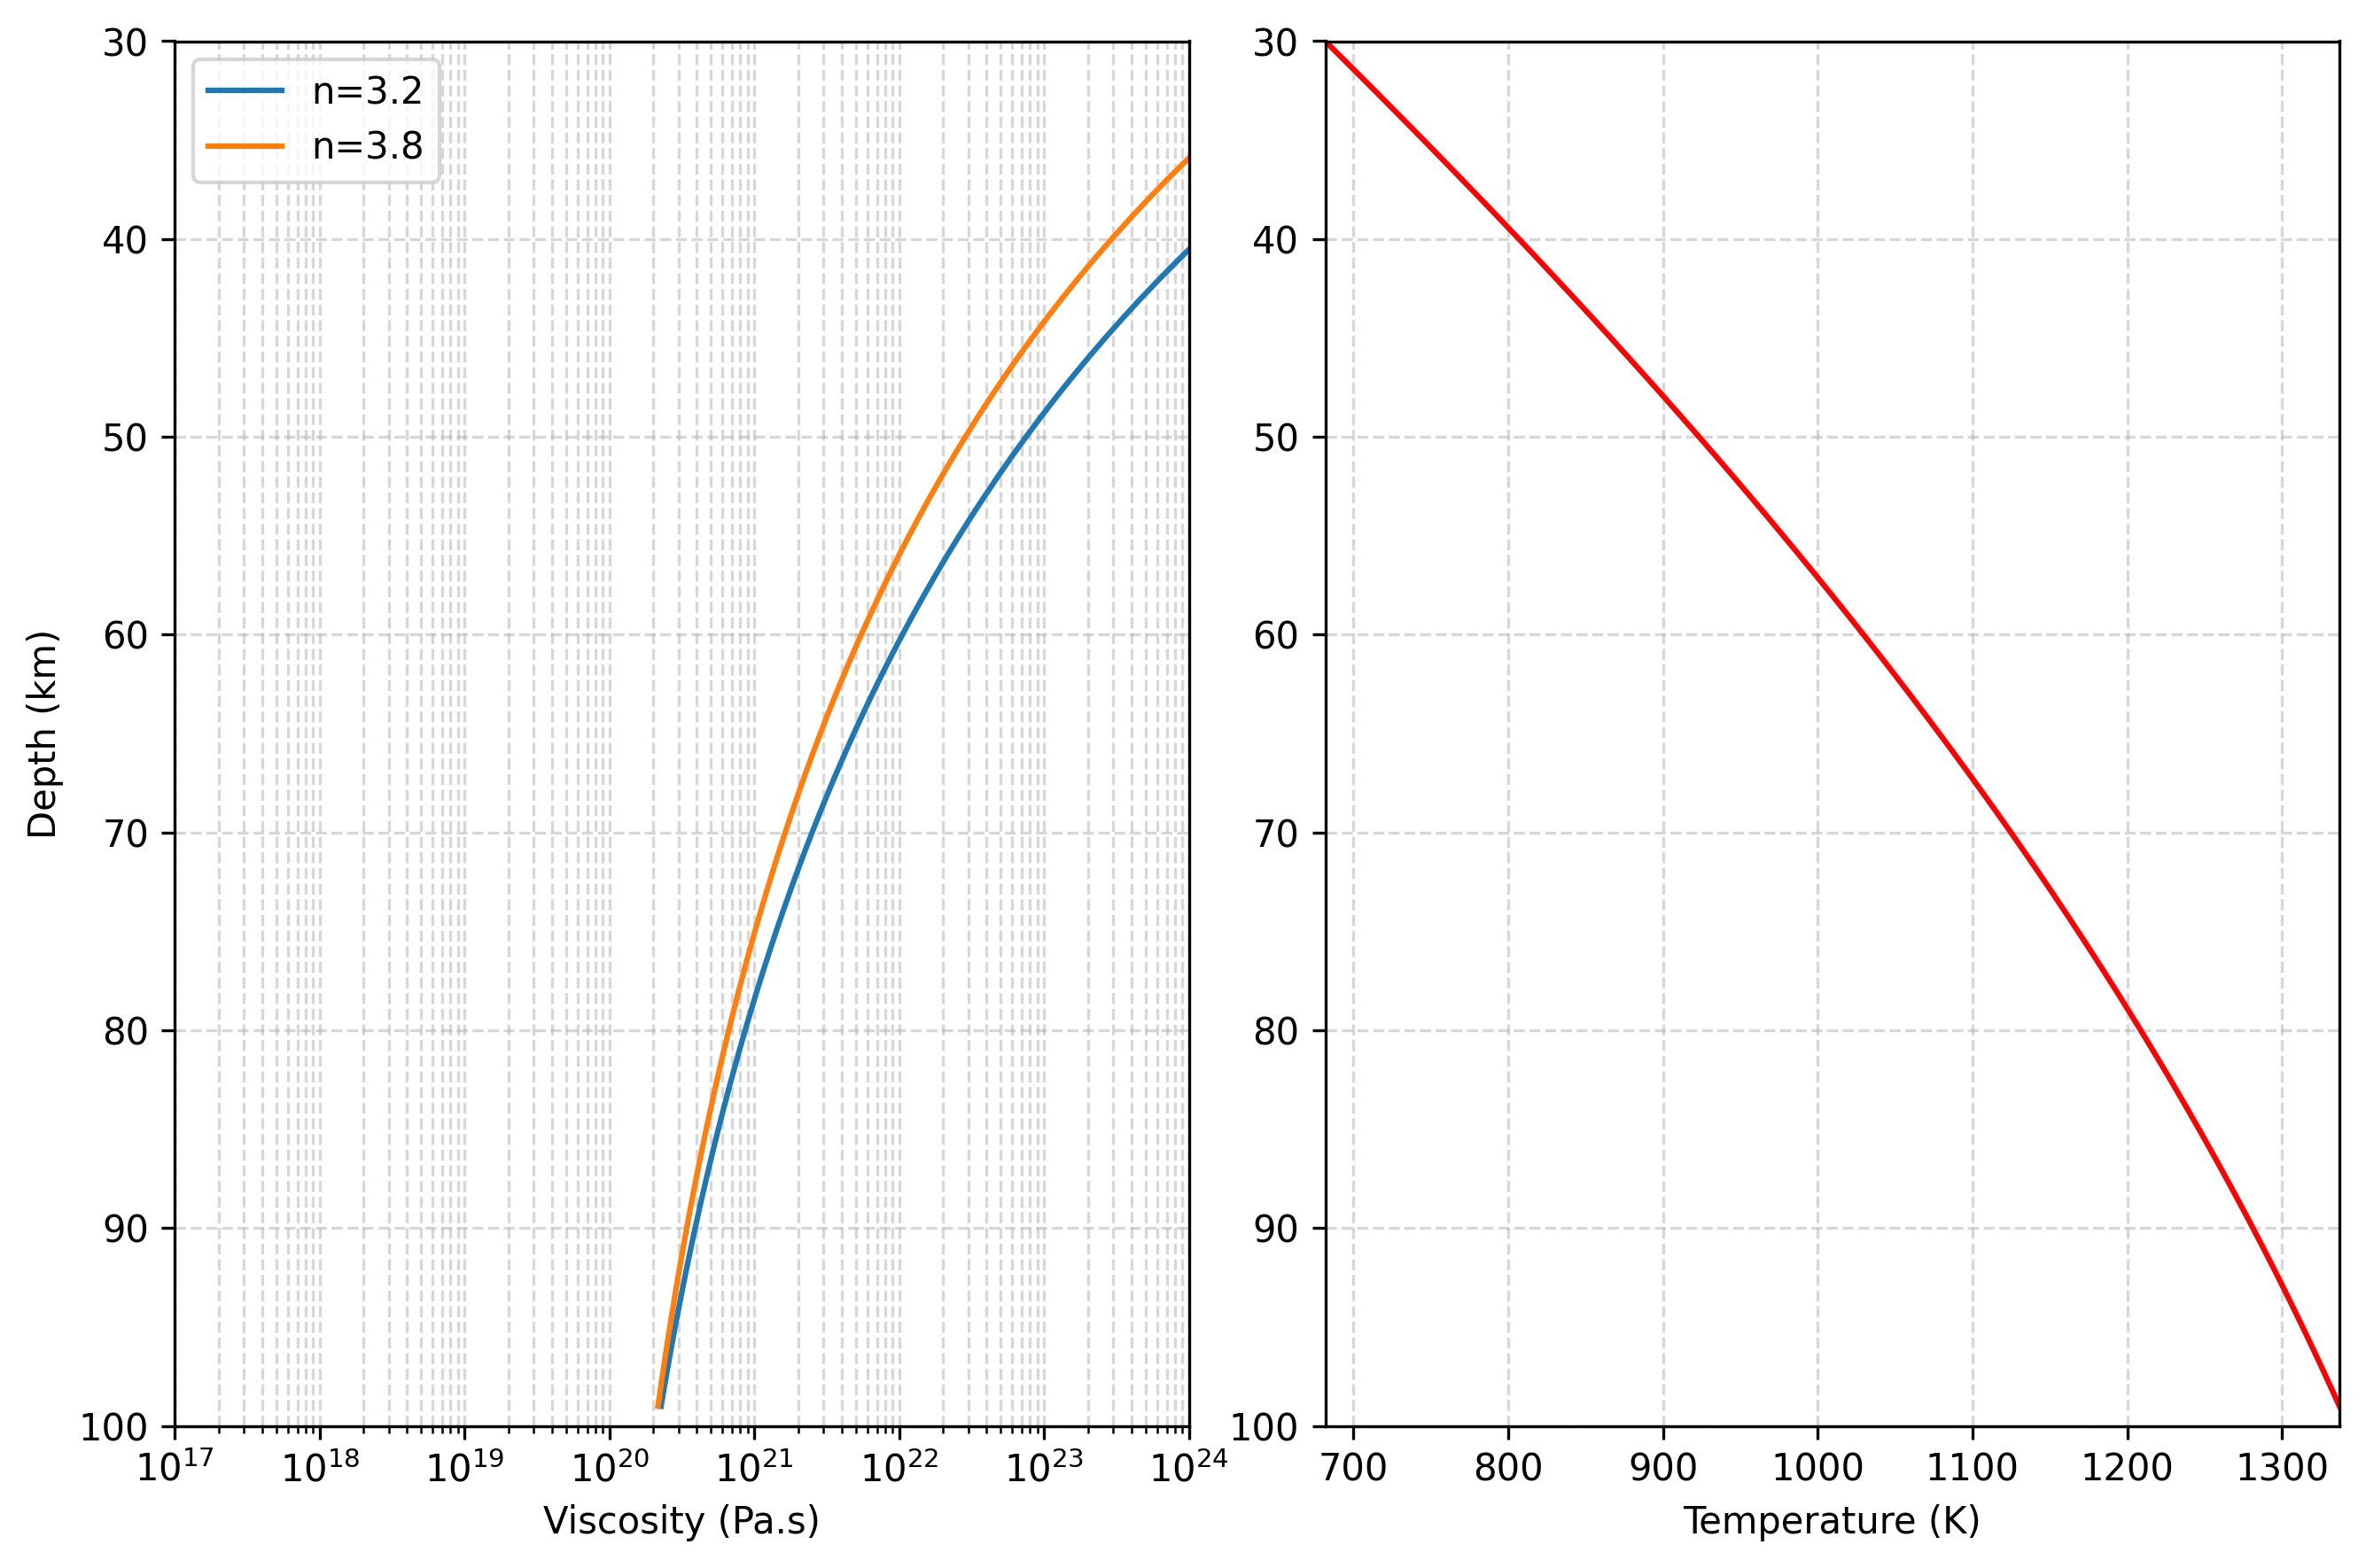

In [14]:
depth = np.arange(0,100,1)
P     = 3000 * 10 * depth * 1e3
T     = calc_temperature.calc_T(depth, 273, 1300+273, 14, 2)
idx   = np.where(depth>=30)[0]

rh1   = rheology.flow_law(30, 3.2, 0, 0, 1000, 1.2, 480e3, P[idx], 11e-6, T[idx], epsilon=3e-15)
rh2   = rheology.flow_law(30, 3.8, 0, 0, 1000, 1.2, 480e3, P[idx], 11e-6, T[idx], epsilon=3e-15)
plot_rheology(rh1.get_viscosity(), rh2.get_viscosity(), depth[idx], T[idx], label_1="n=3.2", label_2="n=3.8")

## Dislocaiton: Sensitive to water content

2000 1.0
200 1.0


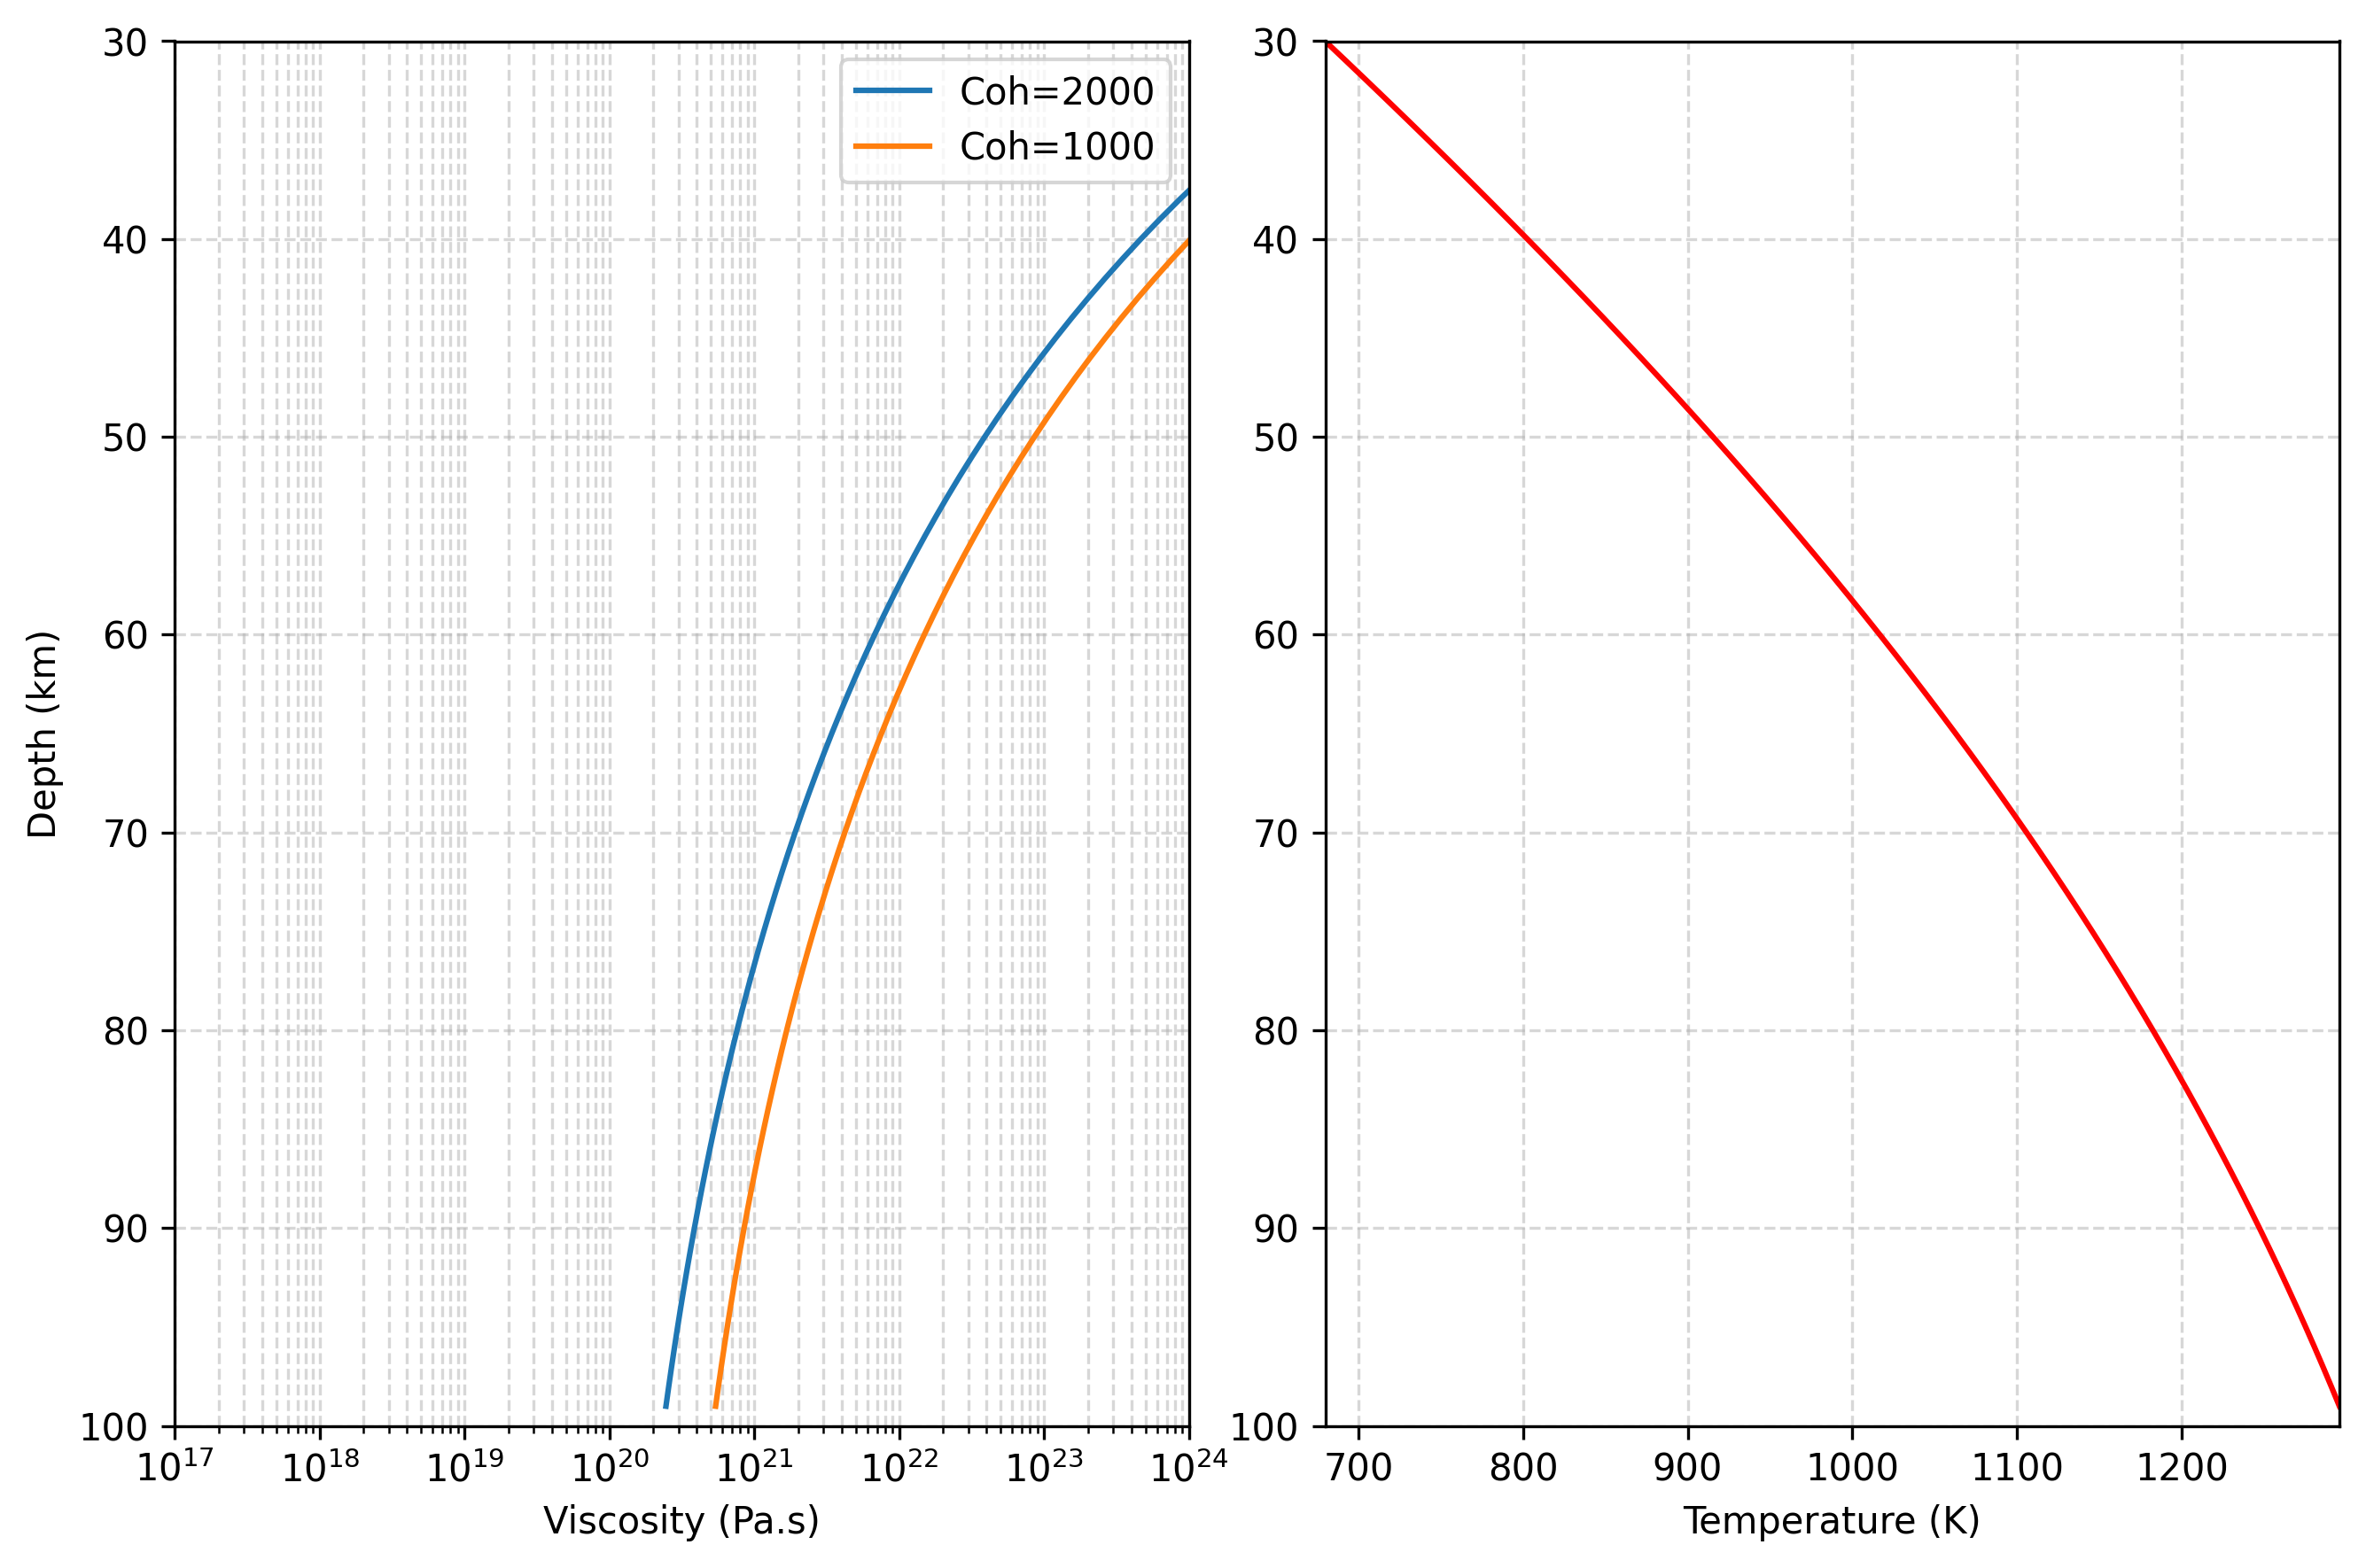

In [10]:
depth = np.arange(0,100,1)
P     = 3000 * 10 * depth * 1e3
T     = calc_temperature.calc_T(depth, 273, 1200+273, 14, 2)
idx   = np.where(depth>=30)[0]

rh1   = rheology.flow_law(30, 3.5, 0, 0, 2000, 1.2, 480e3, P[idx], 10e-6, T[idx], epsilon=3e-15)
rh2   = rheology.flow_law(30, 3.5, 0, 0, 200, 1.2, 480e3, P[idx], 10e-6, T[idx], epsilon=3e-15)
plot_rheology(rh1.get_viscosity(), rh2.get_viscosity(), depth[idx], T[idx], label_1="Coh=2000", label_2="Coh=1000")


## Dislocation: Sensitive to activation energy

1000 1.0
1000 1.0


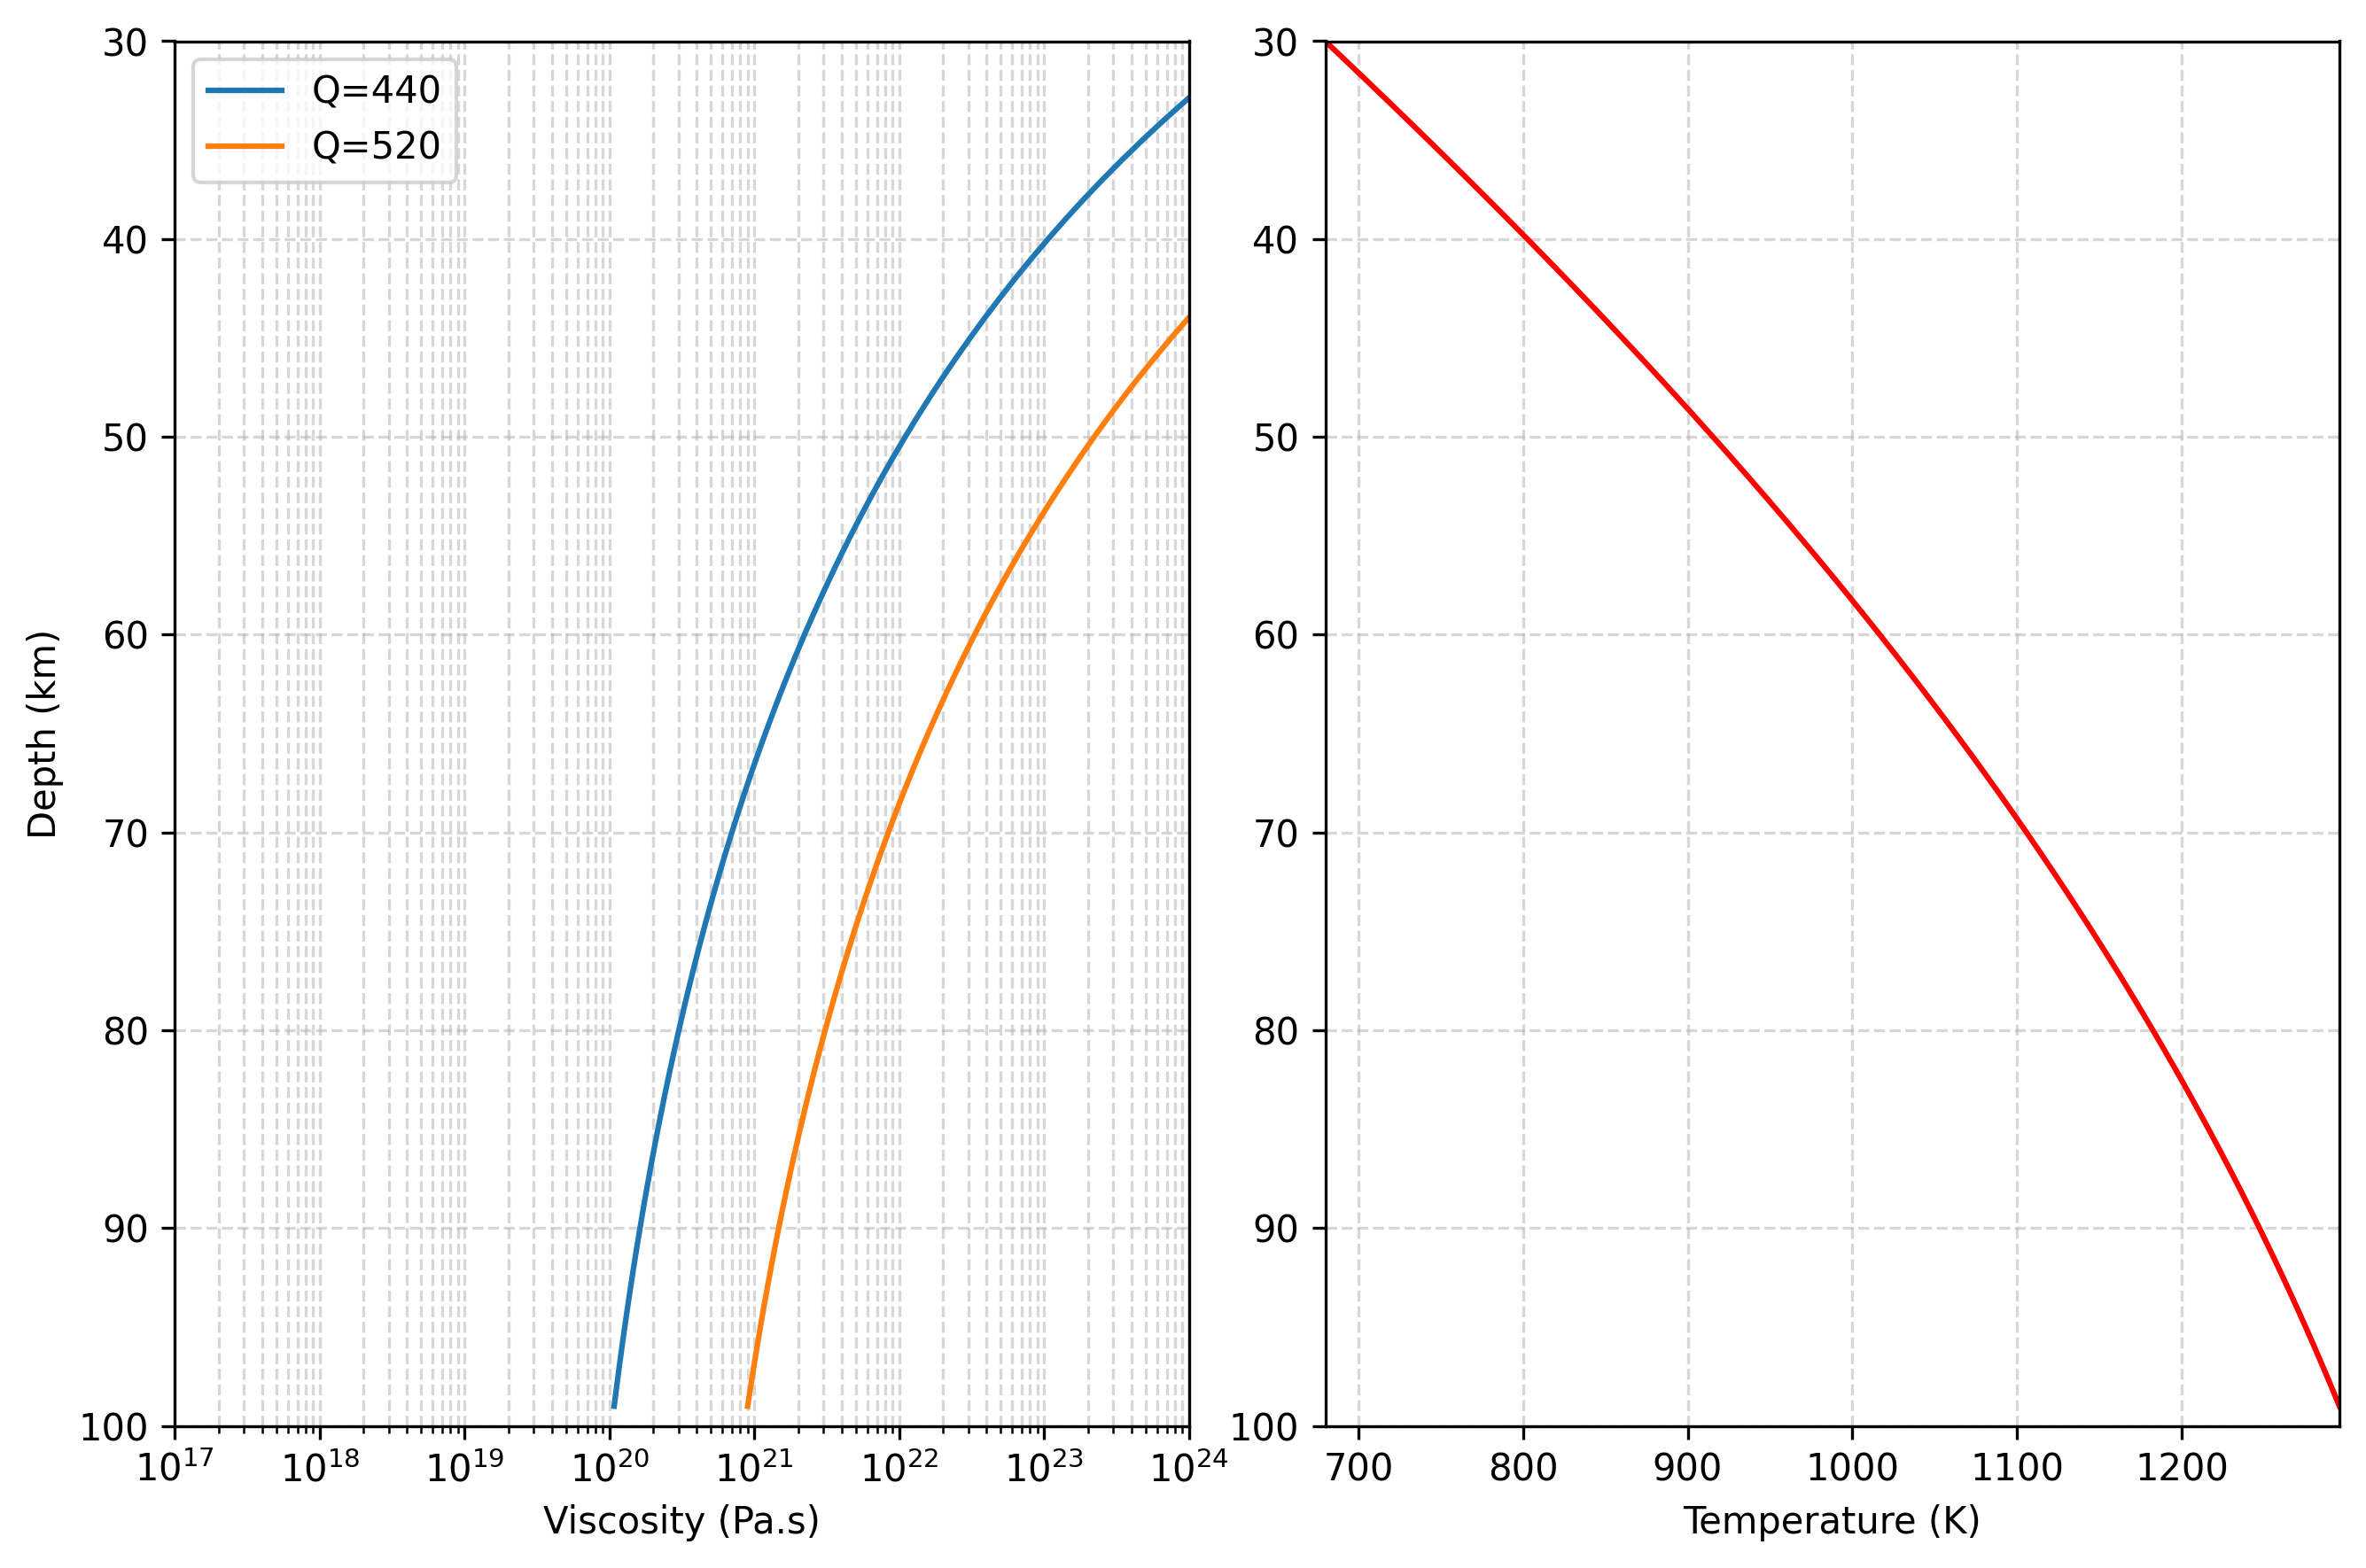

In [11]:
depth = np.arange(0,100,1)
P     = 3000 * 10 * depth * 1e3
T     = calc_temperature.calc_T(depth, 273, 1200+273, 14, 2)
idx   = np.where(depth>=30)[0]

rh1   = rheology.flow_law(30, 3.5, 0, 0, 1000, 1.2, 440e3, P[idx], 10e-6, T[idx], epsilon=3e-15)
rh2   = rheology.flow_law(30, 3.5, 0, 0, 1000, 1.2, 520e3, P[idx], 10e-6, T[idx], epsilon=3e-15)
plot_rheology(rh1.get_viscosity(), rh2.get_viscosity(), depth[idx], T[idx], label_1="Q=440", label_2="Q=520")

## Dislocation: Sensitive to activation volume

1000 1.0
1000 1.0


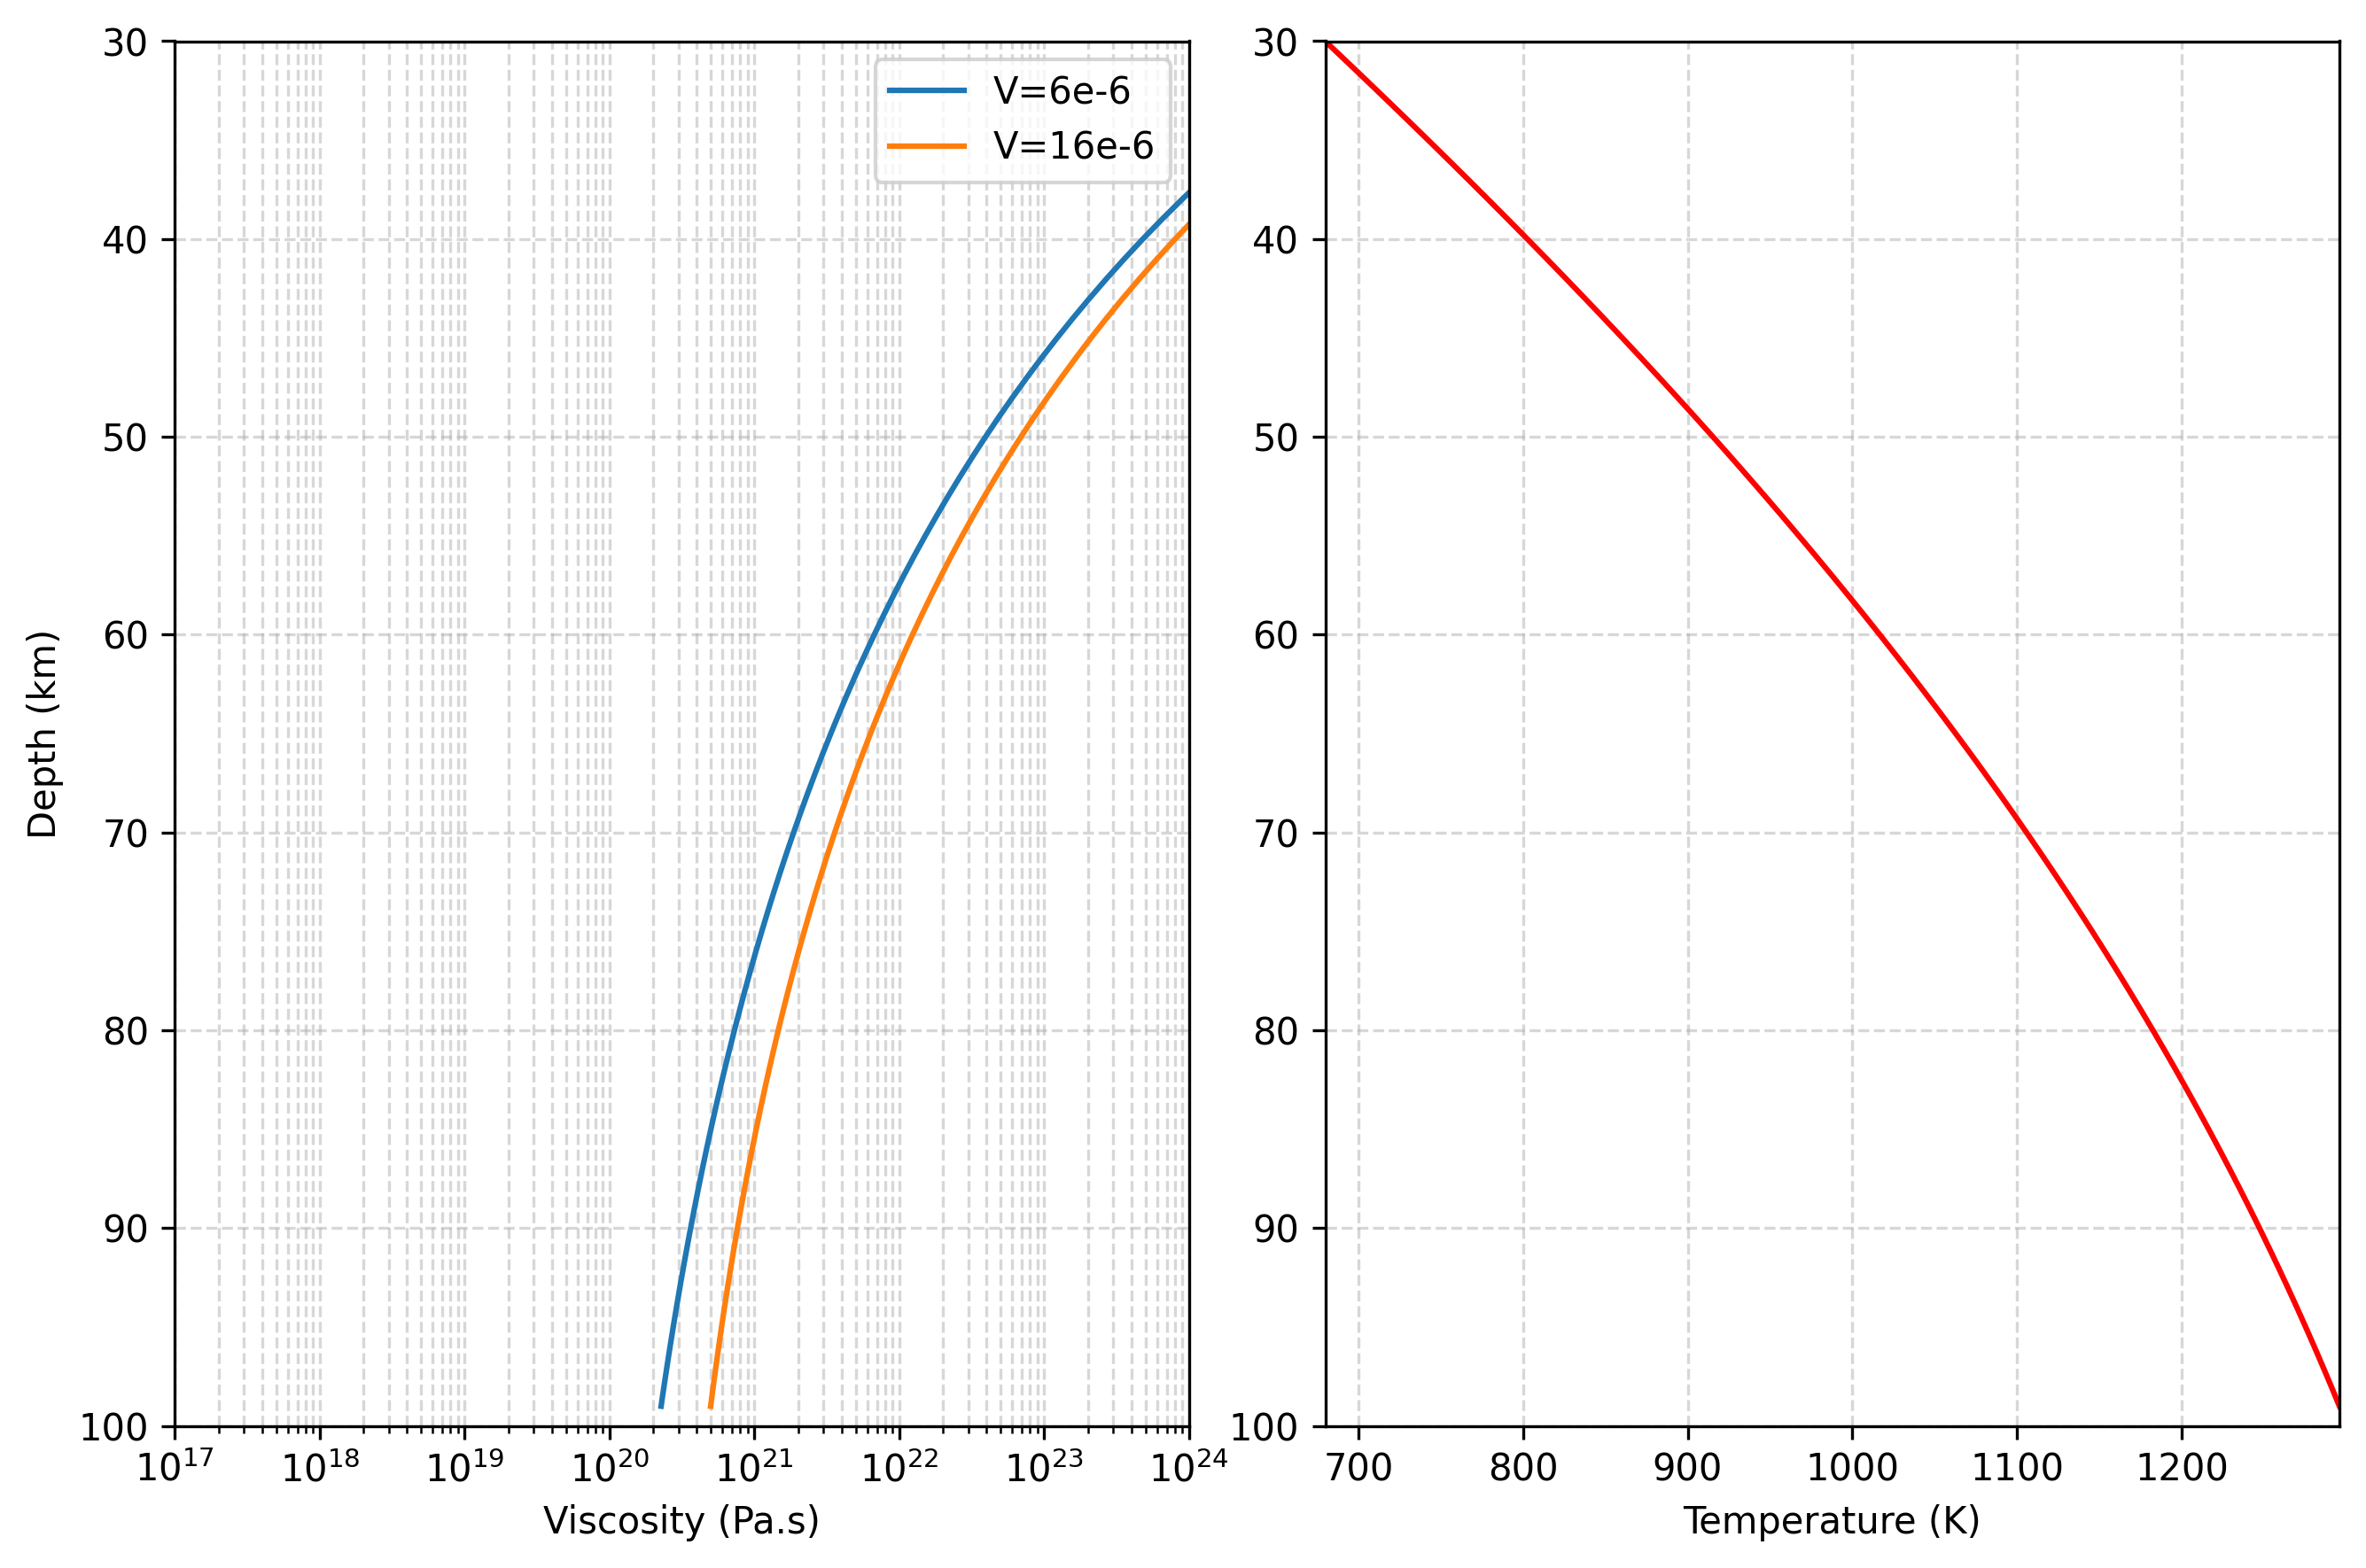

In [39]:
depth = np.arange(0,100,1)
P     = 3000 * 10 * depth * 1e3
T     = calc_temperature.calc_T(depth, 273, 1200+273, 14, 2)
idx   = np.where(depth>=30)[0]

rh1   = rheology.flow_law(30, 3.5, 0, 0, 1000, 1.2, 480e3, P[idx], 6e-6, T[idx], epsilon=3e-15)
rh2   = rheology.flow_law(30, 3.5, 0, 0, 1000, 1.2, 480e3, P[idx], 16e-6, T[idx], epsilon=3e-15)
plot_rheology(rh1.get_viscosity(), rh2.get_viscosity(), depth[idx], T[idx], label_1="V=6e-6", label_2="V=16e-6")

## Diffusion: Sensitive to gain size

1000 1000
1000 1000


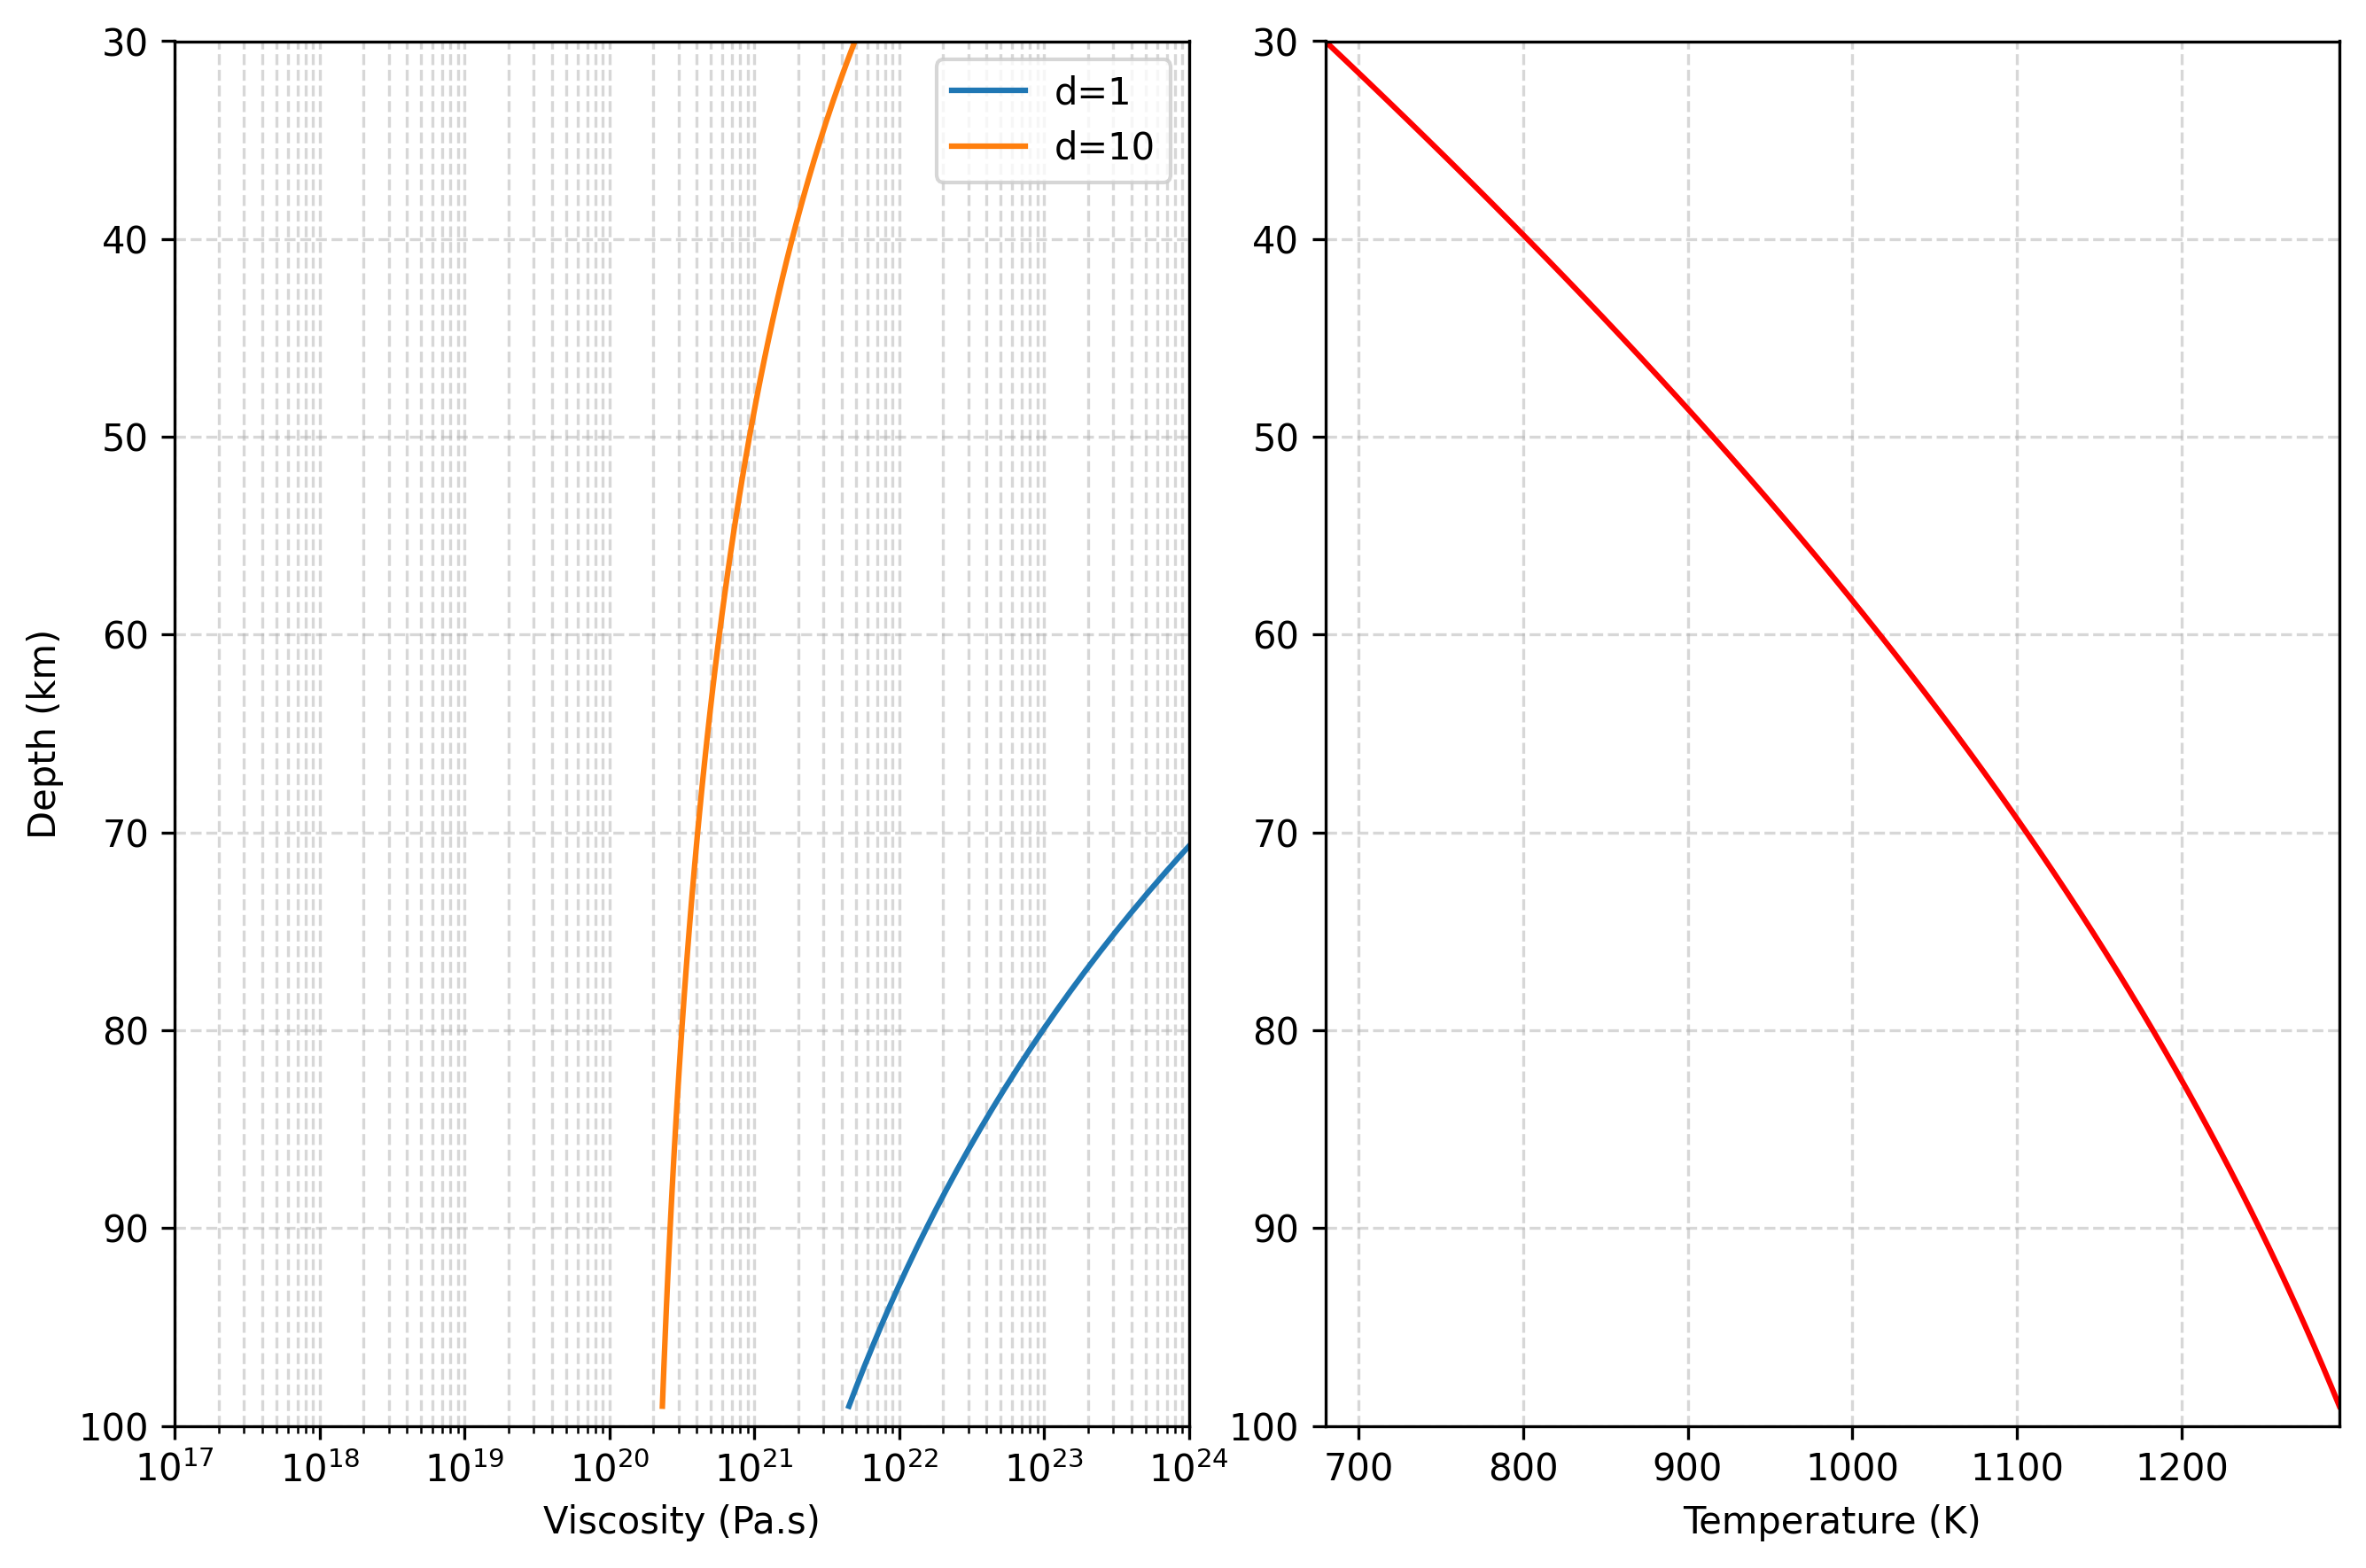

In [40]:
depth = np.arange(0,100,1)
P     = 3000 * 10 * depth * 1e3
T     = calc_temperature.calc_T(depth, 273, 1200+273, 14, 2)
idx   = np.where(depth>=30)[0]

rh1   = rheology.flow_law(3.33e5, 1.0, 1000, 3, 1000, 1.2, 375e3, P[idx], 8e-6, T[idx], epsilon=3e-15)
rh2   = rheology.flow_law(3.33e5, 10, 1000, 3, 1000, 1.2, 375e3, P[idx], 8e-6, T[idx], epsilon=3e-15)
plot_rheology(rh1.get_viscosity(), rh2.get_viscosity(), depth[idx], T[idx], label_1="d=1", label_2="d=10")

## Diffusion: Sensitive to water content

2000 1000
200 1000


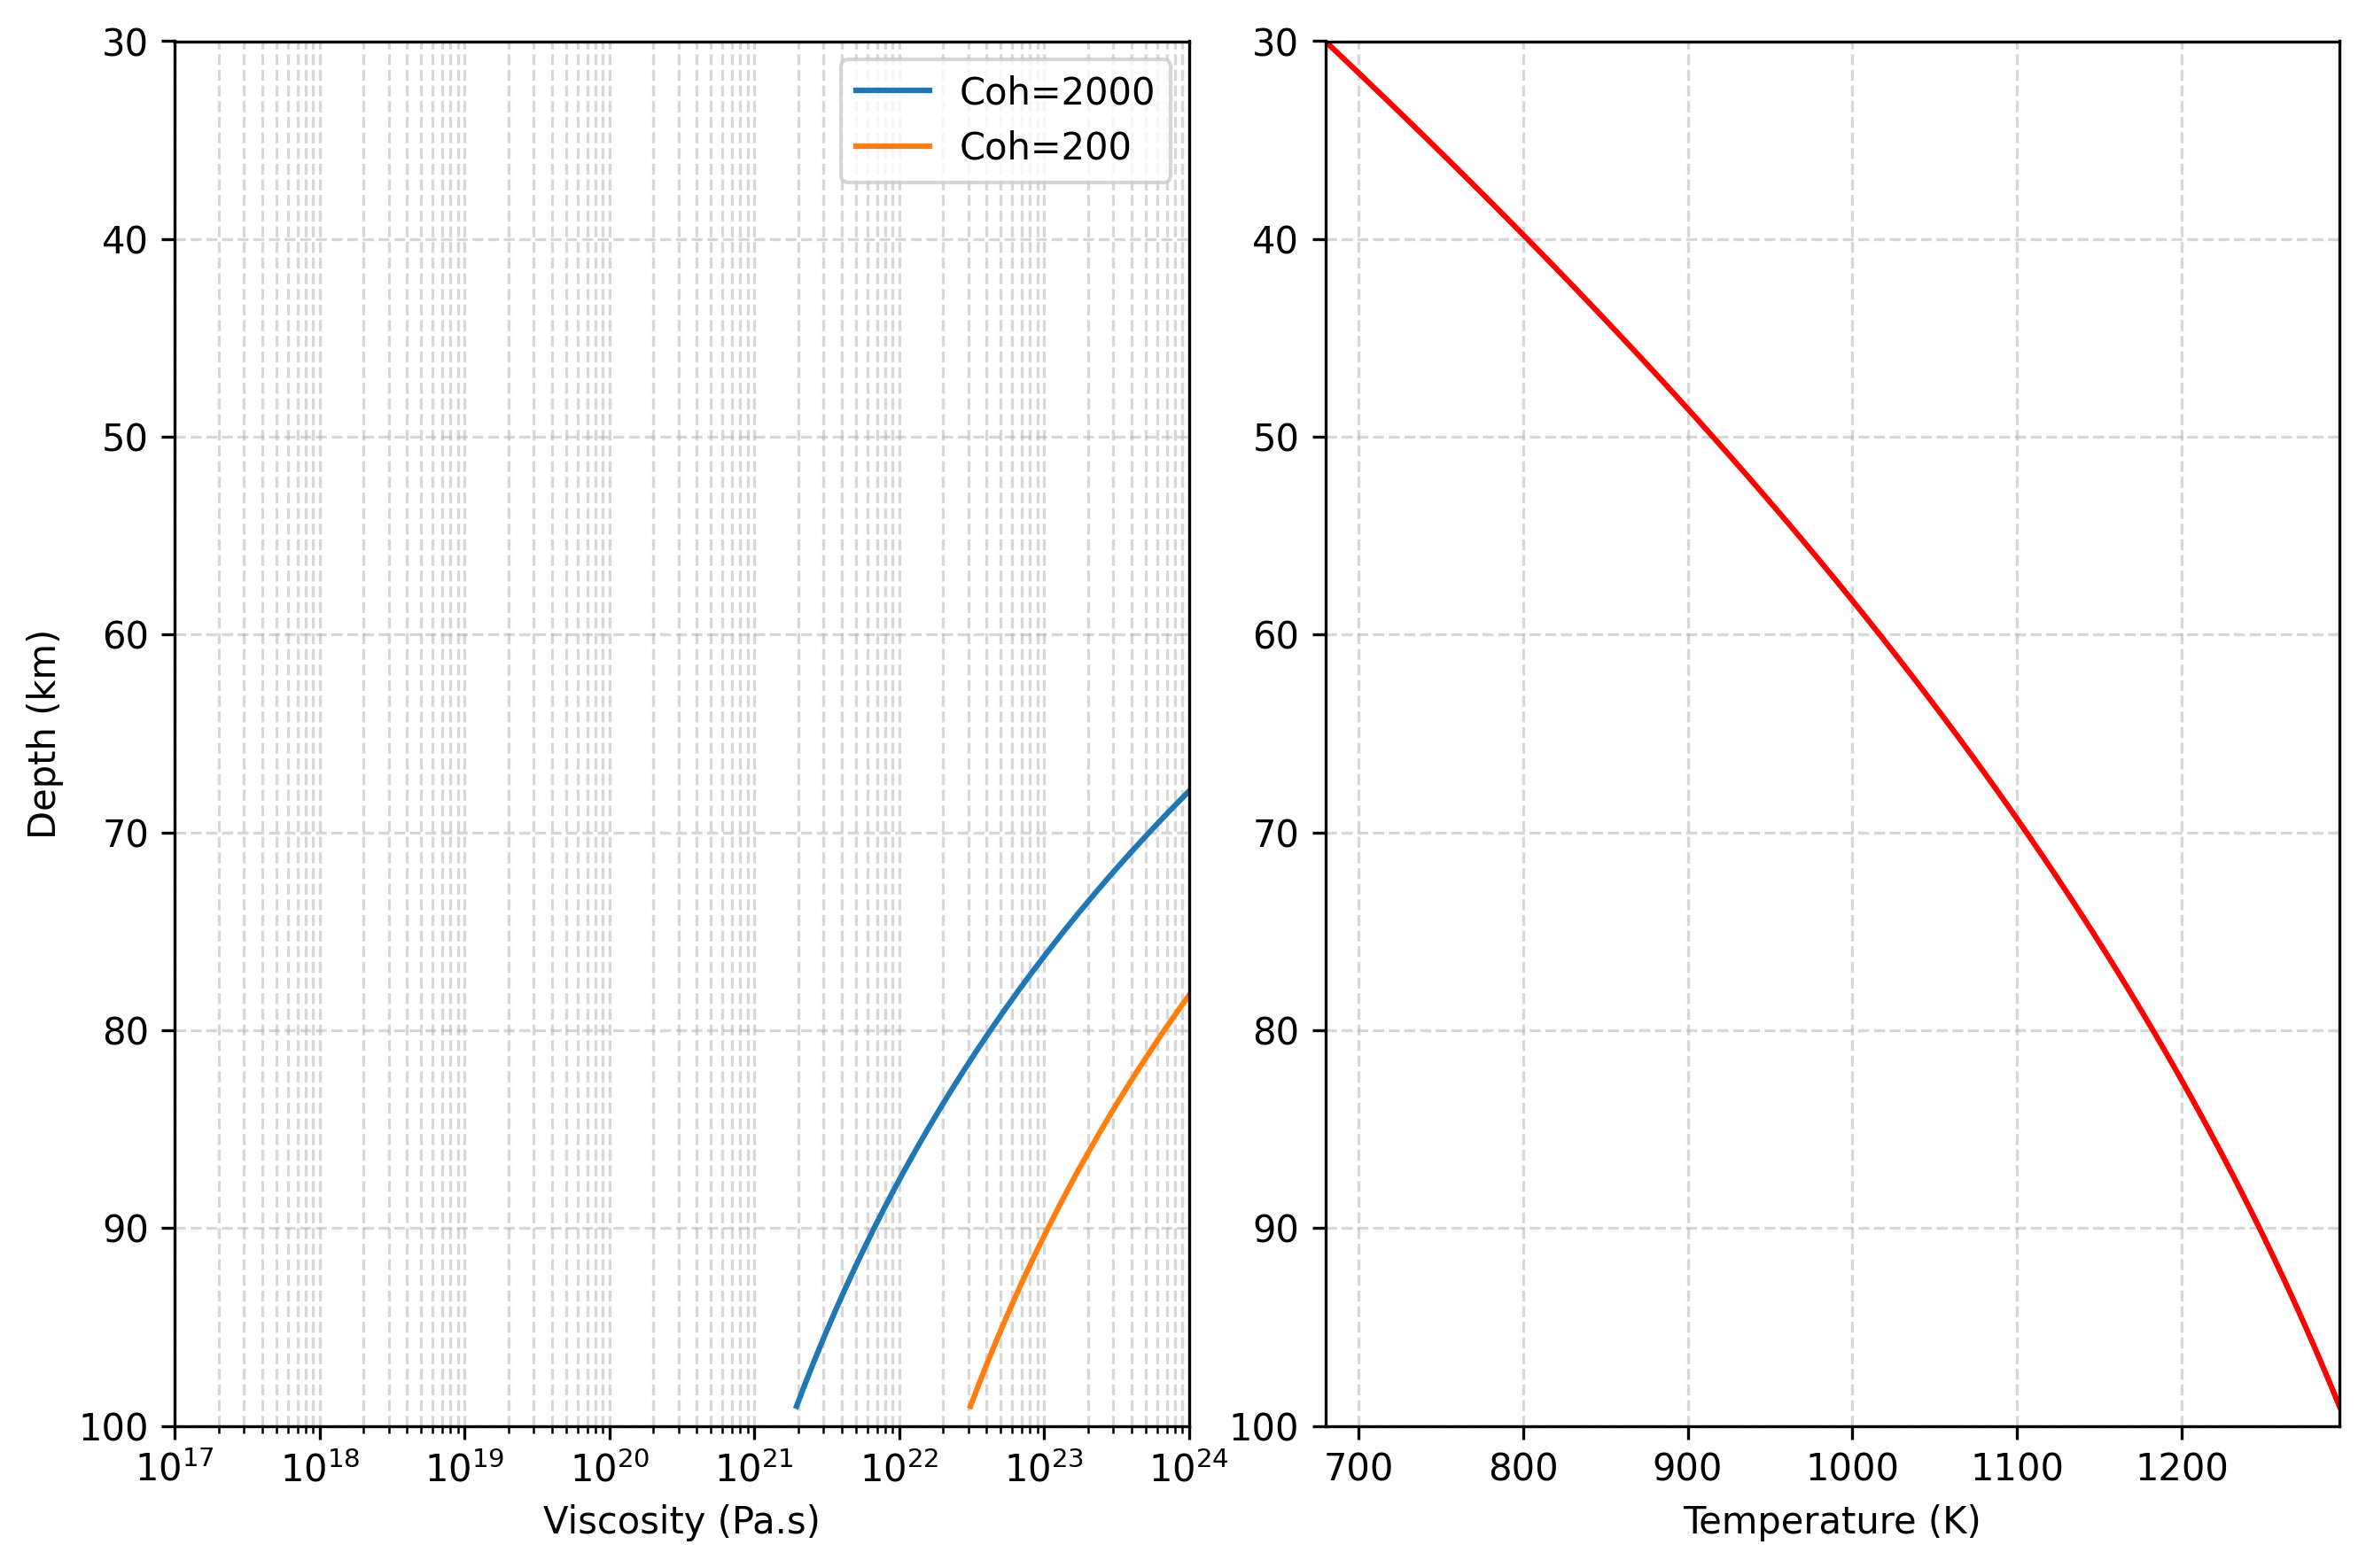

In [41]:
depth = np.arange(0,100,1)
P     = 3000 * 10 * depth * 1e3
T     = calc_temperature.calc_T(depth, 273, 1200+273, 14, 2)
idx   = np.where(depth>=30)[0]

rh1   = rheology.flow_law(3.33e5, 1.0, 1000, 3, 2000, 1.2, 375e3, P[idx], 8e-6, T[idx], epsilon=3e-15)
rh2   = rheology.flow_law(3.33e5, 1.0, 1000, 3, 200, 1.2, 375e3, P[idx], 8e-6, T[idx], epsilon=3e-15)
plot_rheology(rh1.get_viscosity(), rh2.get_viscosity(), depth[idx], T[idx], label_1="Coh=2000", label_2="Coh=200")

1000 1000
1000 1000


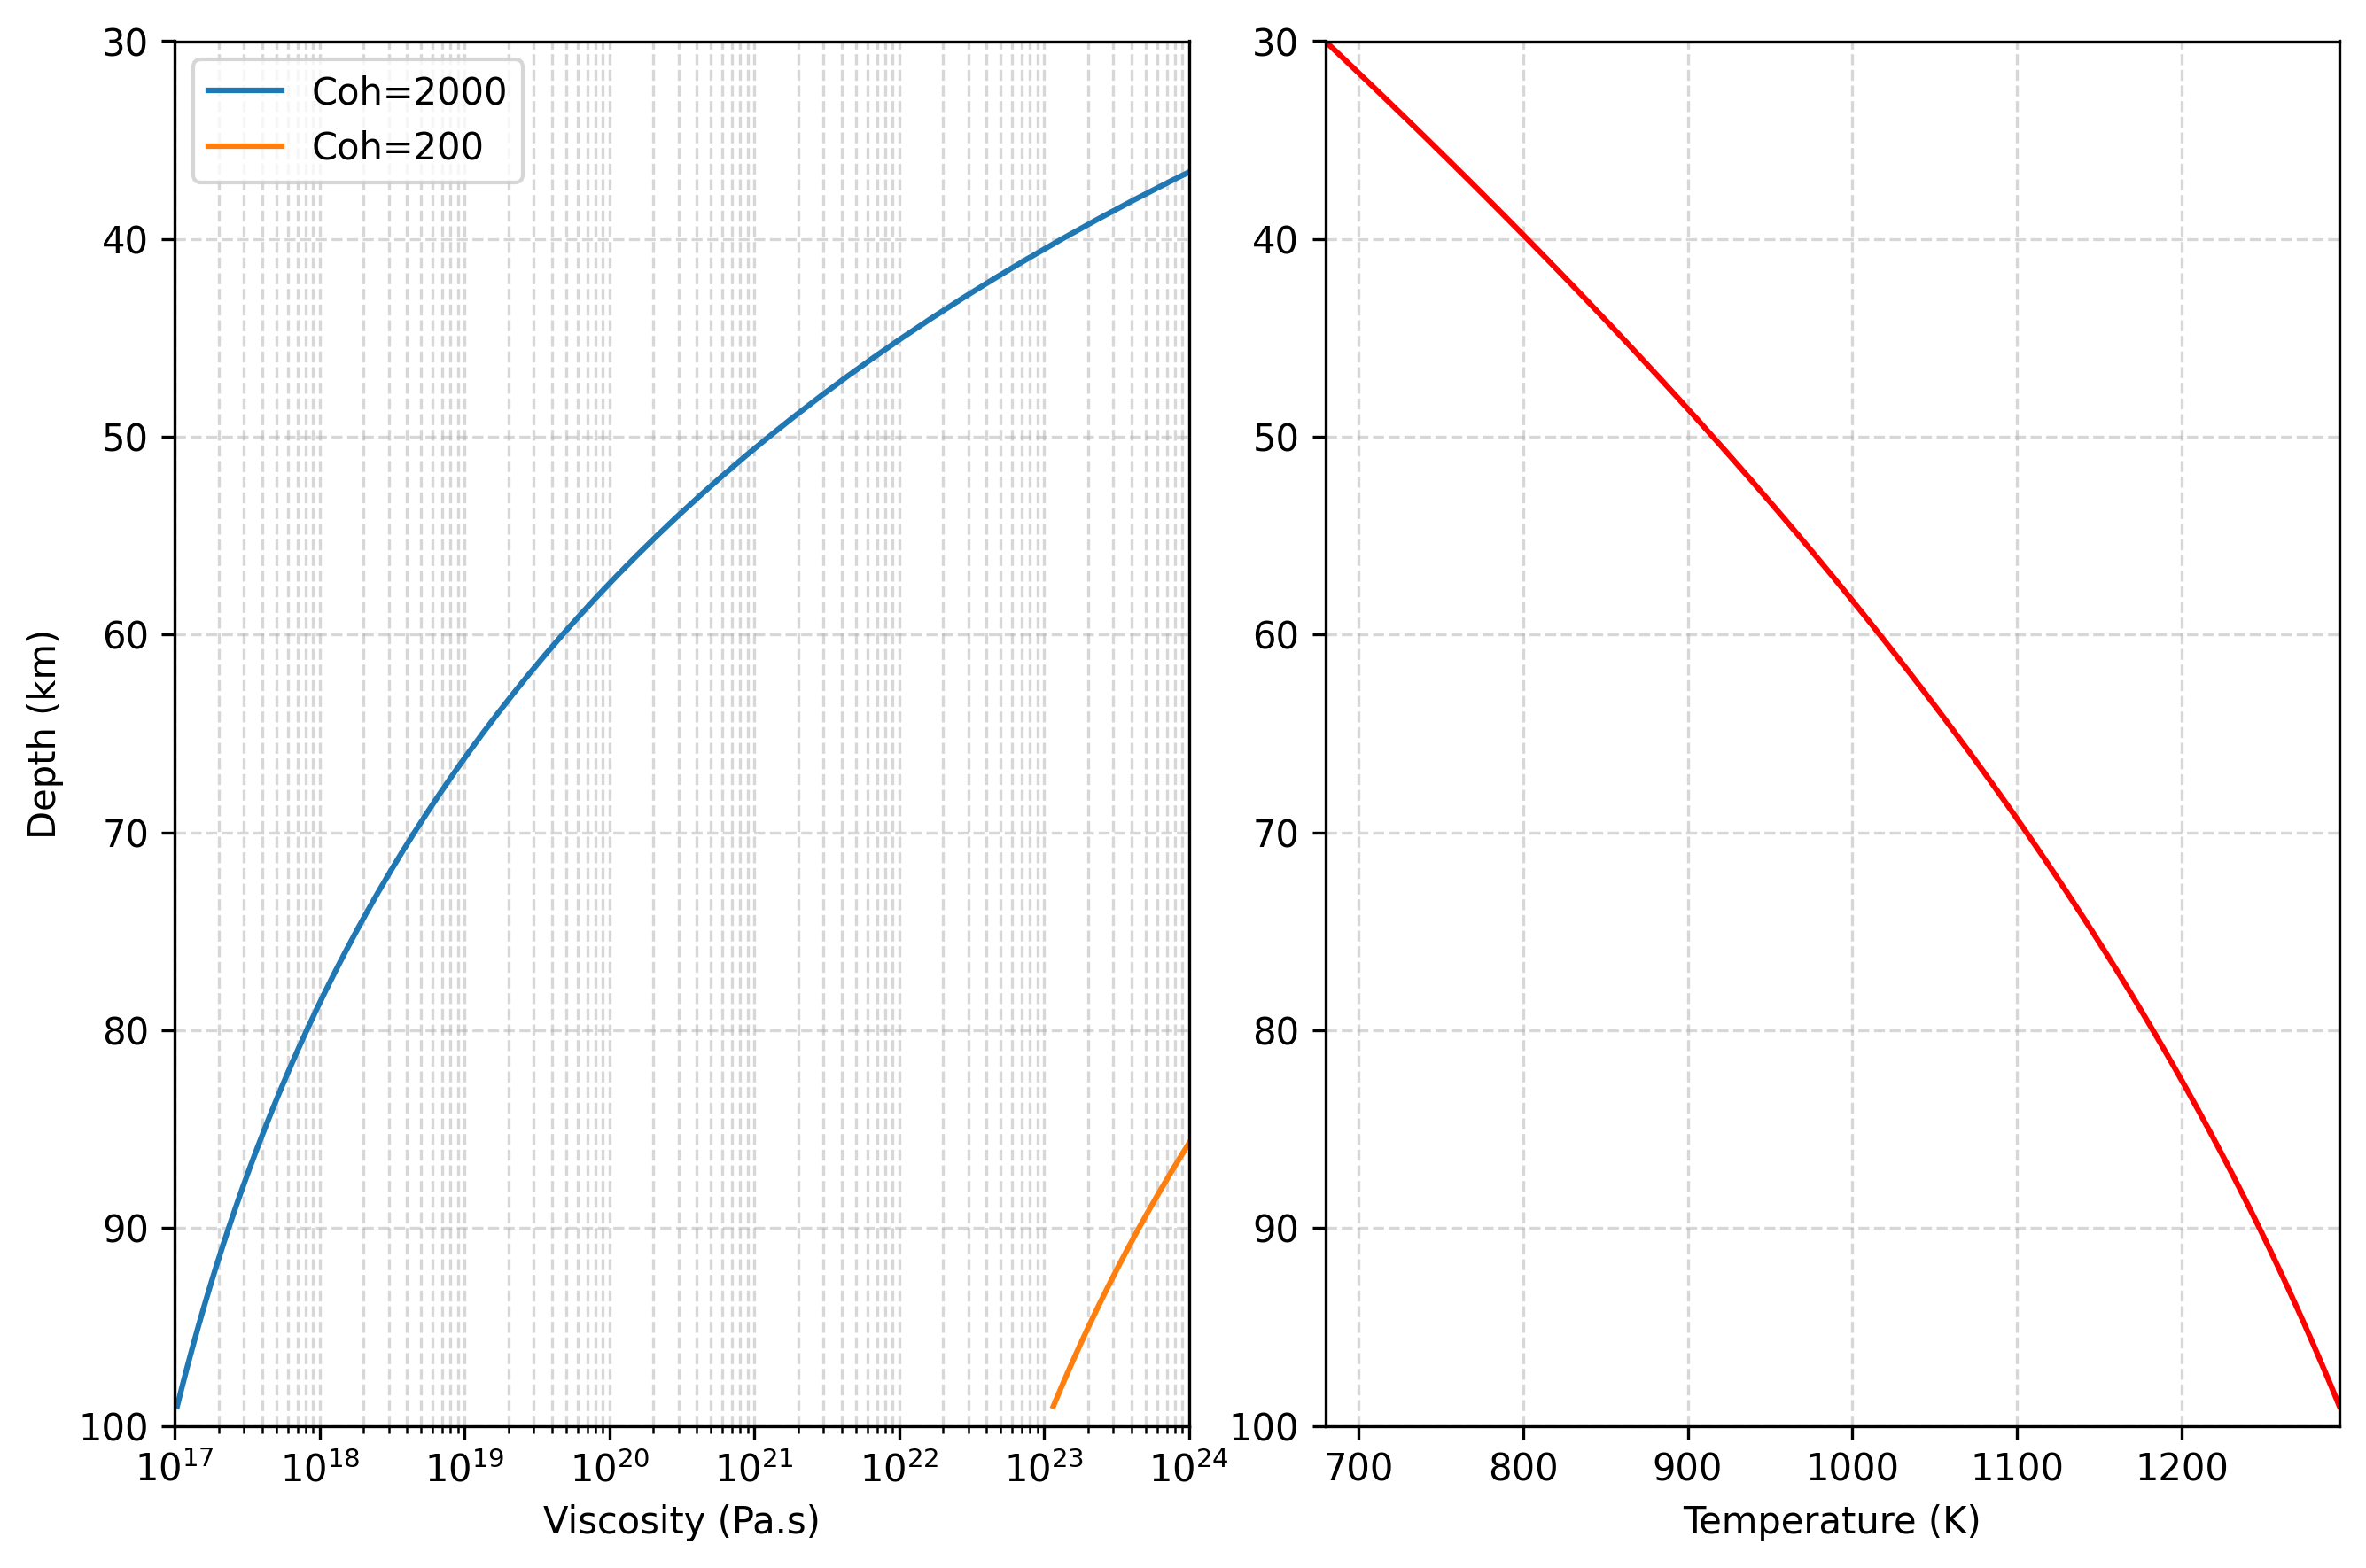

In [42]:
depth = np.arange(0,100,1)
P     = 3000 * 10 * depth * 1e3
T     = calc_temperature.calc_T(depth, 273, 1200+273, 14, 2)
idx   = np.where(depth>=30)[0]

rh1   = rheology.flow_law(3.33e5, 1.0, 1000, 3, 1000, 1.2, 260e3, P[idx], 8e-6, T[idx], epsilon=3e-15)
rh2   = rheology.flow_law(3.33e5, 1.0, 1000, 3, 1000, 1.2, 410e3, P[idx], 8e-6, T[idx], epsilon=3e-15)
plot_rheology(rh1.get_viscosity(), rh2.get_viscosity(), depth[idx], T[idx], label_1="Coh=2000", label_2="Coh=200")

1000 1000
1000 1000


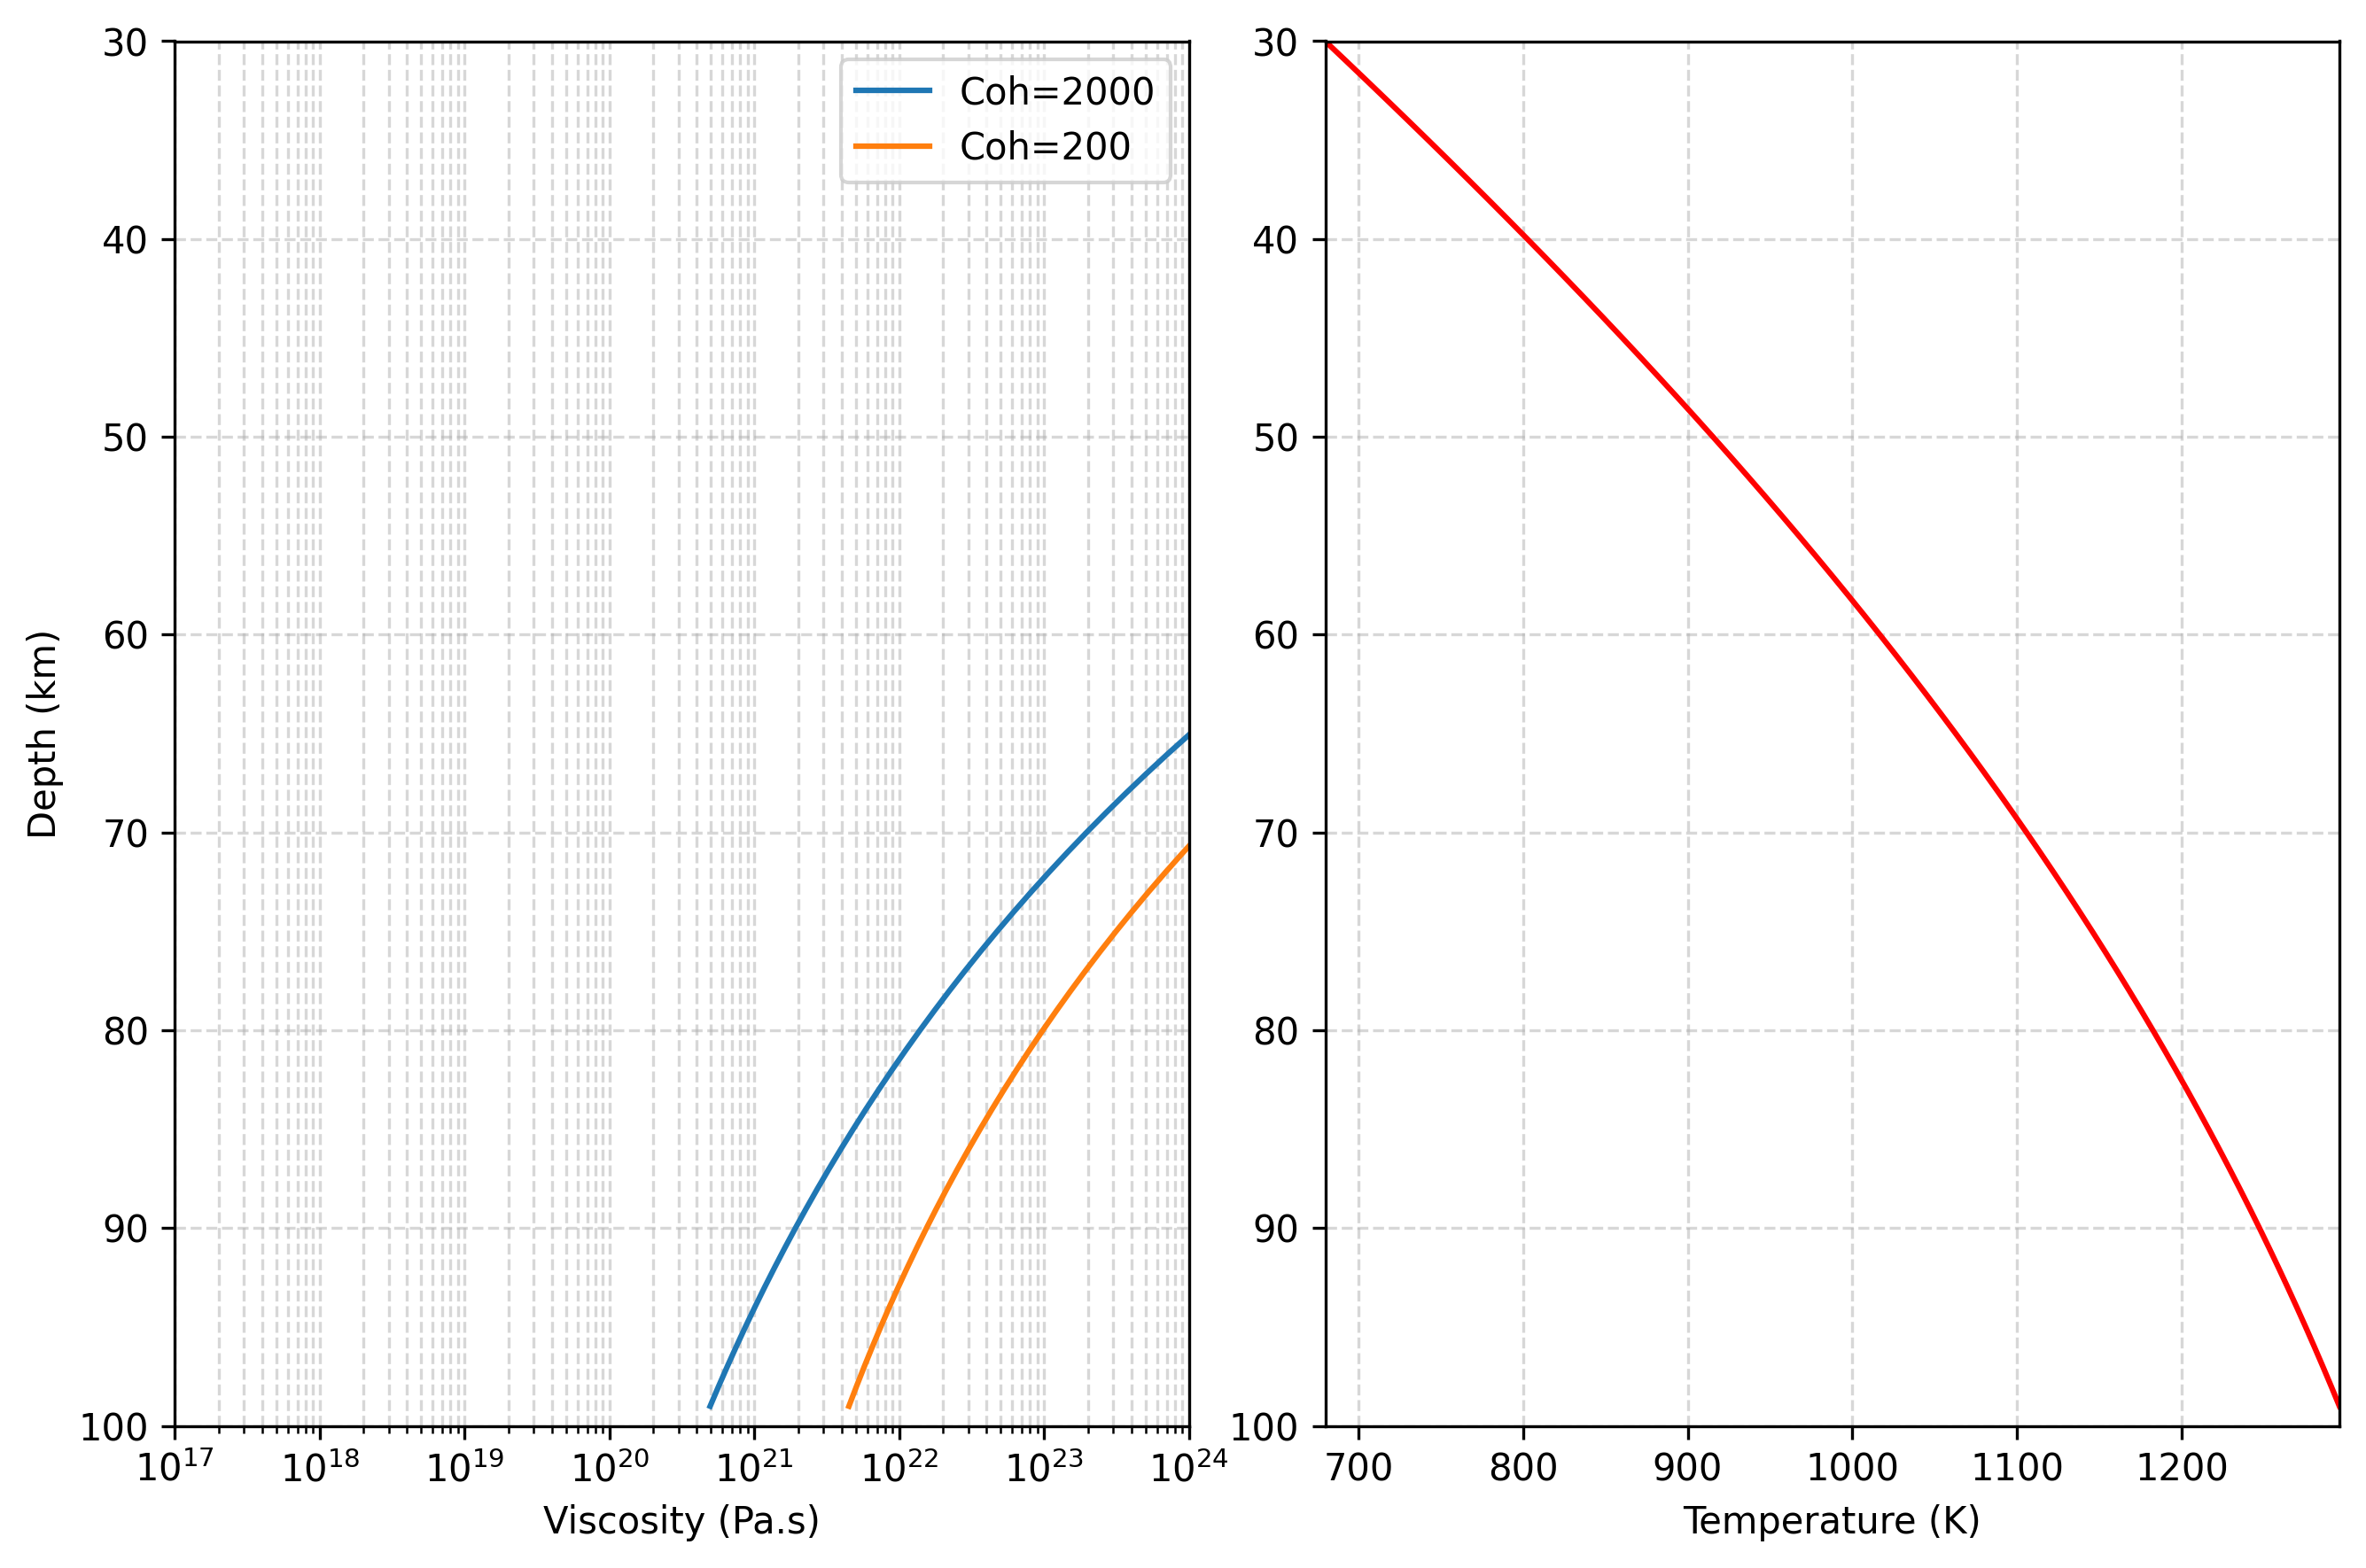

In [43]:
depth = np.arange(0,100,1)
P     = 3000 * 10 * depth * 1e3
T     = calc_temperature.calc_T(depth, 273, 1200+273, 14, 2)
idx   = np.where(depth>=30)[0]

rh1   = rheology.flow_law(3.33e5, 1.0, 1000, 3, 1000, 1.2, 375e3, P[idx], 0, T[idx], epsilon=3e-15)
rh2   = rheology.flow_law(3.33e5, 1.0, 1000, 3, 1000, 1.2, 375e3, P[idx], 8e-6, T[idx], epsilon=3e-15)
plot_rheology(rh1.get_viscosity(), rh2.get_viscosity(), depth[idx], T[idx], label_1="Coh=2000", label_2="Coh=200")